# Video Game Price Analysis: Impact of Inflation and COVID-19

## 1. Introduction

This notebook analyzes how video game prices on Steam have evolved from 2015-2024, with particular focus on the impact of inflation and the COVID-19 pandemic on pricing strategies.

**Research Questions:**

1. **Have video game prices kept pace with inflation?**
   - Do nominal prices track inflation-adjusted values over time?
   - Are games becoming more or less affordable in real terms?

2. **Did COVID-19 cause a structural shift in game pricing?**
   - Were there significant price changes during the pandemic (2020-2022)?
   - Has the post-COVID period (2023-2024) seen a pricing reset?

3. **How has the market composition changed across price tiers?**
   - Are publishers shifting toward premium pricing or budget titles?
   - Do psychological price points (€9.99, €19.99, €59.99, etc.) still dominate?

**Methodology:**

We adjust all historical game prices to 2024 euros using the Harmonised Index of Consumer Prices (HICP) for the European Union. This allows us to compare "real" prices across years and determine whether the video game industry has followed general inflation trends or diverged from them.

**Key Context:**

Between 2020-2024, Europe experienced significant inflation (~23% cumulative). If game prices had perfectly tracked inflation, a €60 game from 2020 should cost approximately €74 in 2024. However, the industry standard has only recently moved from €60 to €70, suggesting potential price stickiness or consumer resistance to larger increases.

---

## 2. Data Loading & Preparation

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

### 2.1 Load Inflation Data (HICP)

The **Harmonised Index of Consumer Prices (HICP)** is the official measure of consumer price inflation used by the European Central Bank. It tracks the average price change of a basket of goods and services over time.

- **Base year**: 2015 = 100
- **Purpose**: Convert historical game prices to 2024 euros to measure "real" affordability
- **Coverage**: European Union average (appropriate since Steam prices are in euros)

In [2]:
# Load data
df_inflation = pd.read_csv('../data/all_items_hicp.csv')

MAX_YEAR = df_inflation['Year'].max()
print(f"Max year in inflation data: {MAX_YEAR}") 

print(f"For each year, the HICP describes the average inflation rate for all goods and services in a given region. Since we are using prices in Europe, we will be using the European Union HICP.")
df_inflation[df_inflation['Year'].between(2015,2025)]

Max year in inflation data: 2024
For each year, the HICP describes the average inflation rate for all goods and services in a given region. Since we are using prices in Europe, we will be using the European Union HICP.


,Year,European Union,Germany,United States
11,2015,100.00,100.0,100.00
12,2016,100.25,100.4,100.57
13,2017,101.96,102.1,102.34
14,2018,103.89,104.0,104.55
15,2019,105.42,105.5,105.99
16,2020,106.20,105.8,106.80
17,2021,109.28,109.2,112.50
18,2022,119.32,118.7,122.27
19,2023,126.91,125.9,125.94
20,2024,130.21,129.0,128.50


### 2.2 Load Steam Game Data

We load our Steam sales data for games released 2015-2024 (filtered in our exploratory analysis). Since we don't have inflation data for 2025, we exclude any games released after 2024.

In [3]:
steam_sales_path= "../data/steam_sales_post_2015.csv"
df_steam = pd.read_csv(steam_sales_path)

# Convert columns to integers (handling NaN values)
df_steam['release_year'] = df_steam['release_year'].astype(int)
df_steam['rating'] = df_steam['rating'].astype(int)
df_steam['num_reviews'] = df_steam['num_reviews'].astype(int)

# Remove games released after latest available for inflation data, which is 2024.
df_steam = df_steam[df_steam['release_year'] <= 2024]


In [4]:
# Quick overview
print("Dataset info:")
print(df_steam.info())

print("\nFirst 5 rows:")
display(df_steam.head())

print(f"\nShape of dataset: {df_steam.shape}")
print("\nSummary statistics:")
display(df_steam.describe())

print("\nGames per year:")
print(df_steam['release_year'].value_counts().sort_index())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 536 entries, 1 to 682
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   game_name           536 non-null    object 
 1   rating              536 non-null    int64  
 2   num_reviews         536 non-null    int64  
 3   discount_pct        536 non-null    float64
 4   price_eur           536 non-null    float64
 5   original_price_eur  536 non-null    float64
 6   release_date        536 non-null    object 
 7   windows             536 non-null    int64  
 8   linux               536 non-null    int64  
 9   macos               536 non-null    int64  
 10  fetched_at          536 non-null    object 
 11  release_year        536 non-null    int64  
 12  price_range         536 non-null    object 
 13  year_interval       536 non-null    object 
dtypes: float64(3), int64(6), object(5)
memory usage: 62.8+ KB
None

First 5 rows:


,game_name,rating,num_reviews,discount_pct,price_eur,original_price_eur,release_date,windows,linux,macos,fetched_at,release_year,price_range,year_interval
1,Cyberpunk 2077,7,772574,-65.0,20.99,59.99,2020-12-09,1,0,1,2025-08-11 00:00,2020,50-60,2020–2024
2,Rust,7,1038433,-50.0,19.99,39.99,2018-02-08,1,0,1,2025-08-11 00:00,2018,30-40,2015–2019
3,Microsoft Flight Simulator (2020) 40th Anniver...,5,63905,-60.0,27.99,69.99,2020-08-17,1,0,0,2025-08-11 00:00,2020,60+,2020–2024
5,Age of Wonders 4,7,13871,-40.0,29.99,49.99,2023-05-02,1,0,0,2025-08-11 00:00,2023,40-50,2020–2024
7,Sea of Thieves: 2025 Edition,7,309796,-50.0,19.99,39.99,2020-06-03,1,0,0,2025-08-11 00:00,2020,30-40,2020–2024



Shape of dataset: (536, 14)

Summary statistics:


,rating,num_reviews,discount_pct,price_eur,original_price_eur,windows,linux,macos,release_year
count,536.000000,5.360000e+02,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,6.272388,3.060699e+04,-57.555970,10.918713,27.283843,0.998134,0.218284,0.322761,2021.063433
std,1.391719,9.327443e+04,20.027379,7.244172,14.704538,0.043193,0.413467,0.467969,2.644636
min,3.000000,1.200000e+01,-95.000000,0.710000,3.990000,0.000000,0.000000,0.000000,2015.000000
25%,5.000000,1.561000e+03,-75.000000,5.420000,16.790000,1.000000,0.000000,0.000000,2019.000000
50%,7.000000,5.316000e+03,-60.000000,9.890000,24.745000,1.000000,0.000000,0.000000,2022.000000
75%,7.000000,2.055725e+04,-45.000000,14.990000,34.990000,1.000000,0.000000,1.000000,2023.000000
max,8.000000,1.038433e+06,-15.000000,55.990000,99.990000,1.000000,1.000000,1.000000,2024.000000



Games per year:
release_year
2015     16
2016     25
2017     28
2018     38
2019     35
2020     66
2021     52
2022     59
2023     93
2024    124
Name: count, dtype: int64


### 2.3 Merge HICP with Game Data

We merge the relevant HICP value for each game based on its release year. 

In [5]:
# Rename the European Union column with HICP data to HICP
df_inflation = df_inflation.rename(columns={'European Union': 'HICP'})

# Merge game data with inflation data
df_games = df_steam.merge(df_inflation[['Year', 'HICP']], 
                          left_on='release_year', 
                          right_on='Year', 
                          how='left')

# Handle missing inflation data (games outside the inflation data range) by filling using the nearest available year
df_games['HICP'] = (
    df_games.groupby('release_year')['HICP']
    .transform(lambda x: x.ffill().bfill())
)


---

## 3. Inflation Adjustment Methodology

We adjust all historical prices to 2024 euros using the formula:

**Adjusted Price (2024) = Original Price × (HICP_2024 / HICP_year)**

Where:
- HICP_2024 = Harmonised Index of Consumer Prices in 2024 (130.21)
- HICP_year = HICP in the game's release year

**How it works:**
- A game released in 2020 for €60 when HICP was 106.2
- In 2024, HICP is 130.21
- Adjustment factor = 130.21 / 106.2 = 1.226
- Adjusted price = €60 × 1.226 = **€73.55**

This means: *"A €60 game in 2020 would need to cost €73.55 in 2024 to maintain the same real value."*

If the 2024 price is lower than the adjusted price, games have become **more affordable** in real terms.

In [6]:
# Choose base year for adjustment
BASE_YEAR = 2024

# Get base year HICP
base_hicp = df_inflation[df_inflation['Year'] == BASE_YEAR]['HICP'].values[0]

# Calculate adjustment factor
df_games['adjustment_factor'] = base_hicp / df_games['HICP']

# Apply inflation adjustment to original price
# Remove € symbol and convert to float if needed
df_games['original_price_eur'] = df_games['original_price_eur'].astype(float)
df_games['adjusted_price'] = df_games['original_price_eur'] * df_games['adjustment_factor']

print(f"Base year: {BASE_YEAR}, Base HICP: {base_hicp}")
print(f"Price adjustment example:")
df_games[['game_name', 'release_year', 'original_price_eur', 
                'adjusted_price', 'HICP']].head(10)

Base year: 2024, Base HICP: 130.21
Price adjustment example:


,game_name,release_year,original_price_eur,adjusted_price,HICP
0,Cyberpunk 2077,2020,59.99,73.552711,106.20
1,Rust,2018,39.99,50.121262,103.89
2,Microsoft Flight Simulator (2020) 40th Anniver...,2020,69.99,85.813540,106.20
3,Age of Wonders 4,2023,49.99,51.289874,126.91
4,Sea of Thieves: 2025 Edition,2020,39.99,49.031054,106.20
5,Hearts of Iron IV,2024,49.99,49.990000,130.21
6,The Elder Scrolls® Online,2017,19.99,25.528618,101.96
7,Cyberpunk 2077: Phantom Liberty,2023,29.99,30.769820,126.91
8,Fallout 76,2020,39.99,49.031054,106.20
9,Stellaris,2016,39.99,51.941126,100.25


---

## 4. Defining Price Tiers

To understand how the market is structured, we need to categorize games into price tiers. We'll explore two approaches:

1. **Statistical Approach**: Quartile-based tiers (equal distribution)
2. **Market-Based Approach**: Psychological price points (real-world pricing)

--- 

### 4.1 Approach 1: Statistical Quartiles (Why They Fail)

Let's start with a statistical approach - dividing games into quartiles based on their inflation-adjusted prices.


In [7]:
# Calculate percentiles
p25 = df_games['adjusted_price'].quantile(0.25)
p50 = df_games['adjusted_price'].quantile(0.50)
p75 = df_games['adjusted_price'].quantile(0.75)

print(f"Percentile thresholds:")
print(f"25th percentile: €{p25:.2f}")
print(f"50th percentile: €{p50:.2f}")
print(f"75th percentile: €{p75:.2f}")

# Create price tiers using pd.cut
df_games['quartile_tier'] = pd.cut(df_games['adjusted_price'],
                                 bins=[0, p25, p50, p75, np.inf],
                                 labels=['Budget', 'Mid-Low', 'Mid-High', 'Premium'],
                                 include_lowest=True)

# Check tier distribution
print("\nPrice tier distribution:")
print(df_games['quartile_tier'].value_counts().sort_index())

Percentile thresholds:
25th percentile: €19.28
50th percentile: €25.69
75th percentile: €41.03

Price tier distribution:
quartile_tier
Budget      134
Mid-Low     134
Mid-High    135
Premium     133
Name: count, dtype: int64


**Visualizing the Quartile Boundaries:**

Let's see how the overall quartile approach divides the market into four equal groups based on the entire dataset's price distribution.

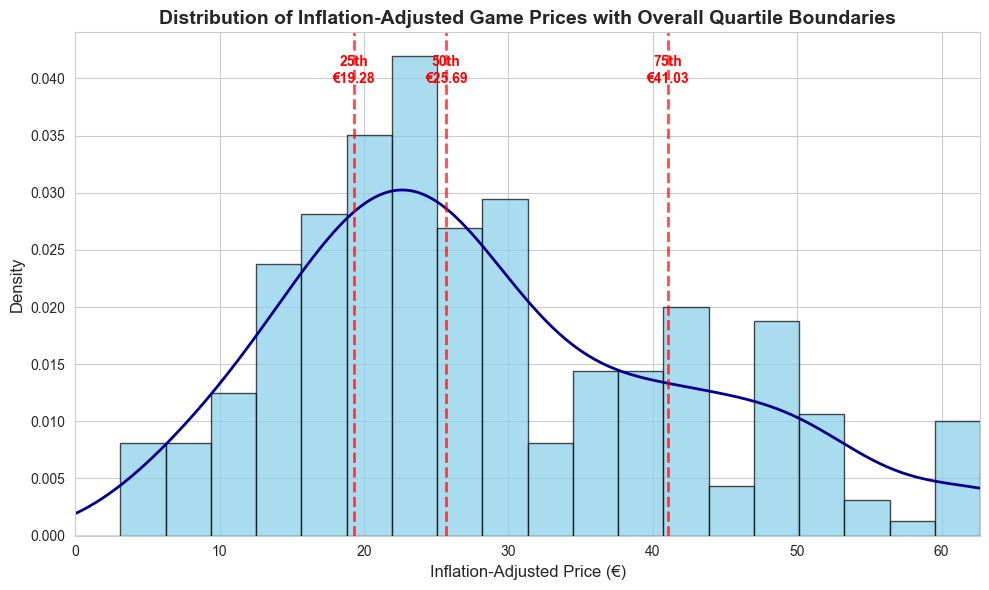

In [8]:
# Price Distribution with Overall Quartile Boundaries
num_bins = 20

ap = pd.to_numeric(df_games['adjusted_price'], errors='coerce').dropna()
low, high = 0, ap.quantile(0.95)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Histogram with KDE
plt.hist(ap, bins=num_bins, range=(low, high), alpha=0.7, color='skyblue',
         edgecolor='black', density=True)
ap.plot(kind='kde', color='darkblue', linewidth=2)

plt.xlabel('Inflation-Adjusted Price (€)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Inflation-Adjusted Game Prices with Overall Quartile Boundaries', 
          fontsize=14, fontweight='bold')
plt.xlim(low, high)

# Percentile lines (quartile boundaries)
for q, label in [(0.25, '25th'), (0.50, '50th'), (0.75, '75th')]:
    val = ap.quantile(q)
    if low <= val <= high:
        plt.axvline(val, color='red', linestyle='--', alpha=0.7, linewidth=2)
        plt.text(val, plt.ylim()[1]*0.9, f'{label}\n€{val:.2f}',
                 ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('price_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

**Problems with Quartile-Based Tiers:**

While statistically clean, this approach has several issues:

1. **Arbitrary Boundaries**: €19.28 has no meaning to consumers or publishers
2. **Ignores Market Reality**: Real prices cluster at .99 endpoints (€9.99, €19.99, €29.99)
3. **Time-Dependent**: Quartiles shift as the market changes, making year-over-year comparison difficult
4. **No Strategic Insight**: Doesn't reflect how publishers actually position their games

Let's examine yearly quartiles to see if relative positioning within each year is more informative:


In [9]:
labels = ['Budget', 'Mid-Low', 'Mid-High', 'Premium']

df_games['adjusted_price'] = pd.to_numeric(df_games['adjusted_price'], errors='coerce')

# Create yearly quartiles - games ranked within their release year
df_games['yearly_quartile_tier'] = (
    df_games.groupby('release_year', group_keys=False)['adjusted_price']
            .apply(lambda s: pd.cut(
                s.rank(method='first', pct=True),  # rank to 0..1 within the year
                bins=[0, .25, .50, .75, 1.0],
                labels=labels,
                include_lowest=True
            ).astype('string'))
)

# Compare overall vs yearly tiers
print("Yearly quartile tier distribution:")
print(df_games['yearly_quartile_tier'].value_counts().sort_index())

# Create a comparison flag
df_games['tiers_match'] = df_games['quartile_tier'] == df_games['yearly_quartile_tier']

print(f"\nTier agreement: {df_games['tiers_match'].sum()} games ({df_games['tiers_match'].mean()*100:.1f}%) have same tier in both approaches")
print(f"Tier mismatch: {(~df_games['tiers_match']).sum()} games ({(~df_games['tiers_match']).mean()*100:.1f}%) have different tiers\n")

# Show examples where tiers DIFFER (the problem!)
print("=" * 80)
print("Examples where yearly and overall quartile tiers DIFFER:")
print("=" * 80)
different_tiers = df_games[~df_games['tiers_match']][['game_name', 'release_year', 'original_price_eur', 
                                                        'adjusted_price', 'quartile_tier', 'yearly_quartile_tier']].sample(5, random_state=123)
display(different_tiers)

print("\n" + "=" * 80)
print("Examples where yearly and overall quartile tiers MATCH:")
print("=" * 80)
same_tiers = df_games[df_games['tiers_match']][['game_name', 'release_year', 'original_price_eur', 
                                                  'adjusted_price', 'quartile_tier', 'yearly_quartile_tier']].sample(5, random_state=123)
display(same_tiers)

Yearly quartile tier distribution:
yearly_quartile_tier
Budget      131
Mid-High    133
Mid-Low     135
Premium     137
Name: count, dtype: Int64

Tier agreement: 416 games (77.6%) have same tier in both approaches
Tier mismatch: 120 games (22.4%) have different tiers

Examples where yearly and overall quartile tiers DIFFER:


,game_name,release_year,original_price_eur,adjusted_price,quartile_tier,yearly_quartile_tier
36,Fallout 4,2015,19.99,26.028979,Mid-High,Budget
519,Expeditions: A MudRunner Game,2024,34.99,34.990000,Mid-High,Premium
503,Power Rangers: Battle for the Grid,2019,16.75,20.688840,Mid-Low,Budget
451,UBOAT,2024,24.99,24.990000,Mid-Low,Mid-High
153,Street Fighter V,2016,19.99,25.964069,Mid-High,Mid-Low



Examples where yearly and overall quartile tiers MATCH:


,game_name,release_year,original_price_eur,adjusted_price,quartile_tier,yearly_quartile_tier
525,Arma 3 Marksmen,2015,7.49,9.752729,Budget,Budget
57,The Stanley Parable: Ultra Deluxe,2022,21.99,23.996965,Mid-Low,Mid-Low
458,Wartales - Contract: The Tavern Opens!,2024,10.99,10.990000,Budget,Budget
224,Blood Bowl 3,2023,29.99,30.769820,Mid-High,Mid-High
279,Valheim,2021,15.49,18.456743,Budget,Budget


**Comparison: Yearly vs Overall Quartiles:**

Let's compare **overall quartiles** (fixed boundaries) with **yearly quartiles** (boundaries that shift each year) across four representative years (2016, 2019, 2020, 2024).

**Key Question**: If we label a game as "Premium" based on yearly quartiles, does that mean the same thing across different years?

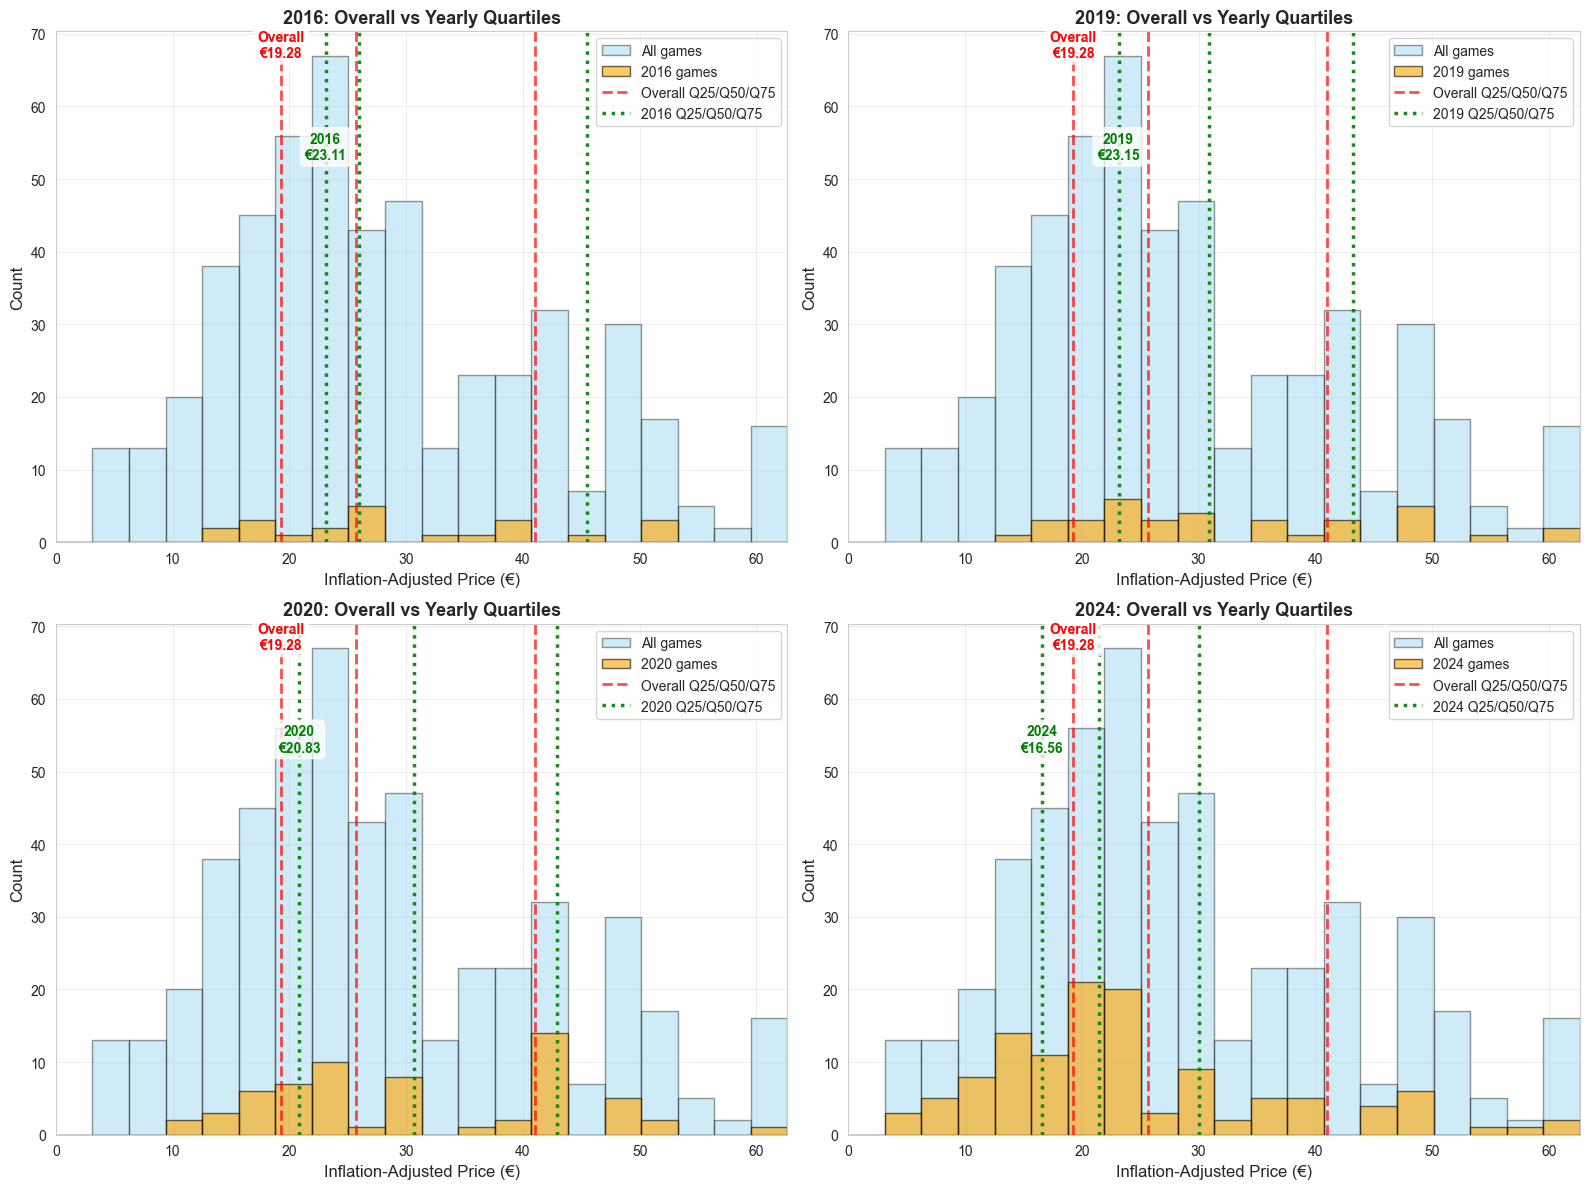


Key Observation:
RED dashed lines = Overall quartiles (same boundaries for all years)
GREEN dotted lines = Yearly quartiles (different boundaries per year)

Notice how the yearly quartiles shift across years, making it impossible to
compare a 'Premium' game from 2016 with a 'Premium' game from 2024 - they
represent completely different price points!

The shift is particularly dramatic between 2019 (pre-COVID) and 2020 (COVID),
showing how market composition changes distort quartile-based tiers.


In [10]:
# Compare overall quartiles vs yearly quartiles for specific years
# 2x2 grid for better visibility
years_to_show = [2016, 2019, 2020, 2024]  # Early, Pre-COVID, COVID, Recent

ap = pd.to_numeric(df_games['adjusted_price'], errors='coerce').dropna()
low, high = 0, ap.quantile(0.95)

# Calculate overall quartiles (same for all plots)
overall_q25 = ap.quantile(0.25)
overall_q50 = ap.quantile(0.50)
overall_q75 = ap.quantile(0.75)

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Convert 2x2 array to 1D for easier indexing

for idx, year in enumerate(years_to_show):
    ax = axes[idx]
    
    # Plot the overall distribution
    ax.hist(ap, bins=20, range=(low, high), alpha=0.4, color='skyblue',
            edgecolor='black', label='All games')
    
    # Highlight games from this specific year
    year_prices = df_games[df_games['release_year'] == year]['adjusted_price'].dropna()
    if len(year_prices) > 0:
        ax.hist(year_prices, bins=20, range=(low, high), alpha=0.6, color='orange',
                edgecolor='black', label=f'{year} games')
    
    # Overall quartile lines (RED - constant across all years)
    ax.axvline(overall_q25, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Overall Q25/Q50/Q75')
    ax.axvline(overall_q50, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax.axvline(overall_q75, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # Yearly quartile lines (GREEN - specific to this year)
    if len(year_prices) > 0:
        yearly_q25 = year_prices.quantile(0.25)
        yearly_q50 = year_prices.quantile(0.50)
        yearly_q75 = year_prices.quantile(0.75)
        
        ax.axvline(yearly_q25, color='green', linestyle=':', alpha=0.9, linewidth=2.5, label=f'{year} Q25/Q50/Q75')
        ax.axvline(yearly_q50, color='green', linestyle=':', alpha=0.9, linewidth=2.5)
        ax.axvline(yearly_q75, color='green', linestyle=':', alpha=0.9, linewidth=2.5)
        
        # Add text labels showing the difference
        ax.text(overall_q25, ax.get_ylim()[1]*0.95, f'Overall\n€{overall_q25:.2f}', 
                ha='center', color='red', fontsize=10, fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax.text(yearly_q25, ax.get_ylim()[1]*0.75, f'{year}\n€{yearly_q25:.2f}', 
                ha='center', color='green', fontsize=10, fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Inflation-Adjusted Price (€)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'{year}: Overall vs Yearly Quartiles', fontsize=13, fontweight='bold')
    ax.set_xlim(low, high)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('quartile_comparison_by_year.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nKey Observation:")
print("=" * 80)
print("RED dashed lines = Overall quartiles (same boundaries for all years)")
print("GREEN dotted lines = Yearly quartiles (different boundaries per year)")
print("\nNotice how the yearly quartiles shift across years, making it impossible to")
print("compare a 'Premium' game from 2016 with a 'Premium' game from 2024 - they")
print("represent completely different price points!")
print("\nThe shift is particularly dramatic between 2019 (pre-COVID) and 2020 (COVID),")
print("showing how market composition changes distort quartile-based tiers.")

### The Problem with Yearly Quartiles: A Concrete Example

Consider **Expeditions: A MudRunner Game** (2024, €34.99):
- **Overall quartile tier**: "Mid-High" ✓ (correct - €35 is a mid-tier game)
- **Yearly quartile tier (2024)**: "Premium" ✗ (incorrect - €35 is NOT premium!)

**Why does this misclassification happen?**

In 2024, many cheap indie games were released, which pushed that year's quartile boundaries downward. A €35 game becomes "premium" relative to 2024's distribution, even though €35 has never been considered a premium price in the gaming industry.

**The Fundamental Issue:**

Yearly quartiles are distorted by each year's market composition:
- Year with many indie releases -> quartile boundaries shift DOWN -> mid-priced games mislabeled as "premium"
- Year with fewer indie releases -> quartile boundaries shift UP -> premium games mislabeled as "mid-tier"

This instability makes year-over-year comparisons meaningless. A "Premium" game in 2024 means something completely different than a "Premium" game in 2020.

**Solution:** Use stable, market-recognized price points (€9.99, €19.99, €59.99, etc.) that aren't affected by the indie/AAA mix in any given year.

--- 

Now let's examine tiers using prices points publishers actually use in the market.


### 4.2 Approach 2: Psychological Price Points (The Right Way)

Before defining our tier system, let's examine the **raw price distribution** to see where games naturally cluster.

**The Question:** Do publishers actually use psychological price points (€9.99, €19.99, etc.), or is this just conventional wisdom?

We'll analyze the frequency of each price point in our dataset. If psychological pricing is real, we should see clear spikes at .99 prices.

In [11]:
# Analyze the frequency of each distinct price point
price_freq = df_games['original_price_eur'].value_counts().sort_index()

print("Top 20 Most Common Price Points (Original Price in Euros):")
print("=" * 70)
top_prices = df_games['original_price_eur'].value_counts().head(20).sort_values(ascending=False)

for price, count in top_prices.items():
    pct = (count / len(df_games)) * 100
    print(f"€{price:6.2f}: {count:4d} games ({pct:5.2f}%)")

# Count how many of the top 20 are .99 prices
ninety_nine_prices = sum(1 for price in top_prices.index if abs(price - round(price + 0.01)) < 0.02)
print(f"\n{ninety_nine_prices} out of top 20 prices end in .99 ({ninety_nine_prices/20*100:.0f}%)")

Top 20 Most Common Price Points (Original Price in Euros):
€ 19.99:   51 games ( 9.51%)
€ 24.99:   48 games ( 8.96%)
€ 34.99:   38 games ( 7.09%)
€ 29.99:   37 games ( 6.90%)
€ 39.99:   35 games ( 6.53%)
€ 59.99:   24 games ( 4.48%)
€ 14.99:   24 games ( 4.48%)
€ 49.99:   23 games ( 4.29%)
€ 16.75:   15 games ( 2.80%)
€ 17.99:   12 games ( 2.24%)
€ 20.99:   12 games ( 2.24%)
€ 21.99:    9 games ( 1.68%)
€ 12.79:    9 games ( 1.68%)
€ 19.50:    9 games ( 1.68%)
€ 12.99:    8 games ( 1.49%)
€ 44.99:    7 games ( 1.31%)
€ 24.50:    7 games ( 1.31%)
€ 15.49:    7 games ( 1.31%)
€  9.99:    7 games ( 1.31%)
€ 19.49:    5 games ( 0.93%)

14 out of top 20 prices end in .99 (70%)


### Visualizing Price Clustering

**Key Finding:** 70% of the top 20 most common prices end in .99

The data confirms publishers strategically use psychological price points. Now let's visualize this clustering pattern to see the spikes at .99 prices clearly.

**What to look for:**
- Sharp spikes at €9.99, €14.99, €19.99, €24.99, €29.99, €34.99, €39.99, etc.
- These red vertical lines mark the standard psychological price points
- The histogram bins are €0.50 wide to show fine-grained distribution

If psychological pricing is real, we should see clear concentration of games at these specific price points rather than uniform distribution across all prices.

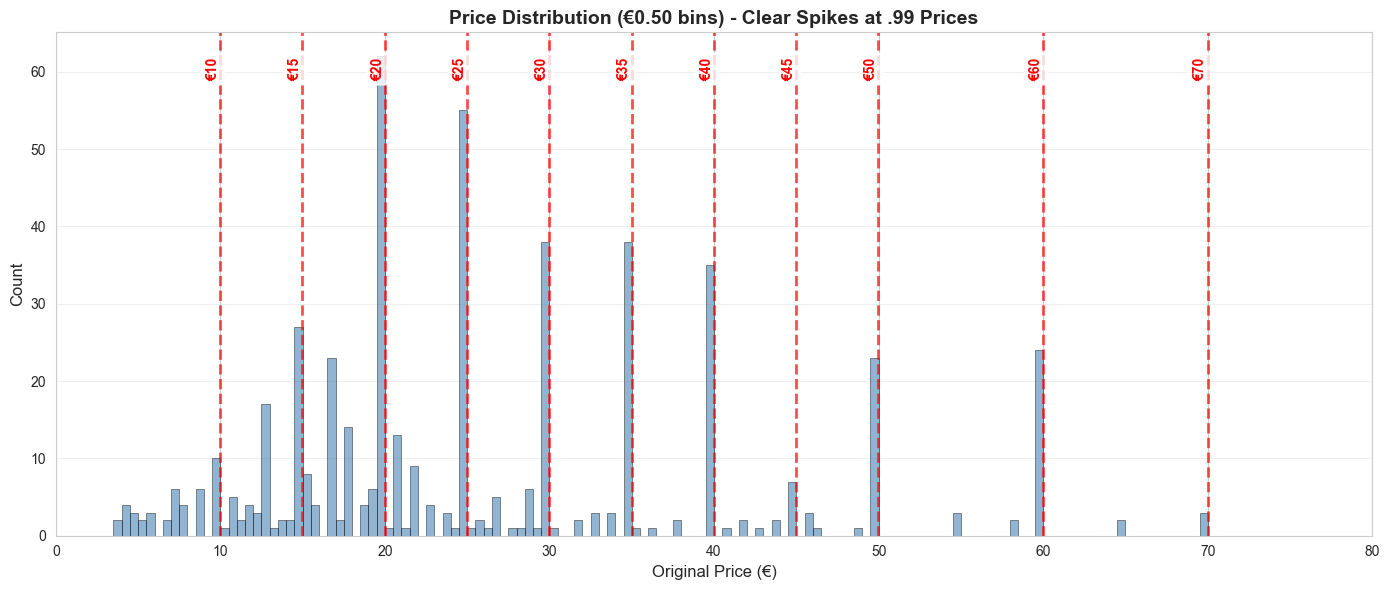

In [12]:
# Visualize the clustering at .99 price points (using original prices)
plt.figure(figsize=(14, 6))

# Fine-grained histogram with €0.50 bins
price_bins_fine = np.arange(0, 80, 0.5)
plt.hist(df_games['original_price_eur'], bins=price_bins_fine, alpha=0.6, 
         color='steelblue', edgecolor='black', linewidth=0.5)

# Highlight .99 price points (including midpoints)
psych_prices = [9.99, 14.99, 19.99, 24.99, 29.99, 34.99, 39.99, 44.99, 49.99, 59.99, 69.99]
for price in psych_prices:
    plt.axvline(price, color='red', linestyle='--', alpha=0.7, linewidth=2)
    plt.text(price, plt.ylim()[1]*0.95, f'€{price:.0f}', 
             rotation=90, ha='right', va='top', color='red', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.xlabel('Original Price (€)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Price Distribution (€0.50 bins) - Clear Spikes at .99 Prices', 
          fontsize=14, fontweight='bold')
plt.xlim(0, 80)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('price_clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Results: Clear Clustering at .99 Price Points

The visualization confirms strong clustering at psychological price points:

**Major Spikes:**
- €19.99 (51 games, 9.5%)
- €24.99 (48 games, 9.0%)
- €34.99 (38 games, 7.1%)
- €29.99 (37 games, 6.9%)

**Why This Matters for Our Analysis:**

These .99 prices are where publishers SET their prices. However, we need to analyze games using **inflation-adjusted prices** to compare a 2016 game fairly with a 2024 game.

**Our Approach:**
1. Publishers use psychological prices at point of sale (€19.99, €29.99, etc.)
2. We adjust these to 2024 euros for fair comparison across years
3. We define tier boundaries based on these known psychological thresholds
4. This gives us stable, meaningful categories that reflect real market structure

Next, we'll define our tier system using these psychological price boundaries, applied to inflation-adjusted prices.

### Finding Natural Breaks in Adjusted Prices

Before finalizing our tier boundaries, let's examine the distribution of inflation-adjusted prices to identify natural breaks. This will help us define ranges that align with how the market actually segments after accounting for inflation.

Distribution of Inflation-Adjusted Prices (2024 €):
Count: 536
Mean:  €30.84
Median: €25.69
Std:   €16.81

Min:   €4.29
Max:   €127.69

Percentiles:
10th percentile: € 12.84
20th percentile: € 17.52
25th percentile: € 19.28
30th percentile: € 20.69
40th percentile: € 24.00
50th percentile: € 25.69
60th percentile: € 30.77
70th percentile: € 37.51
75th percentile: € 41.03
80th percentile: € 43.64
90th percentile: € 51.48
95th percentile: € 62.65


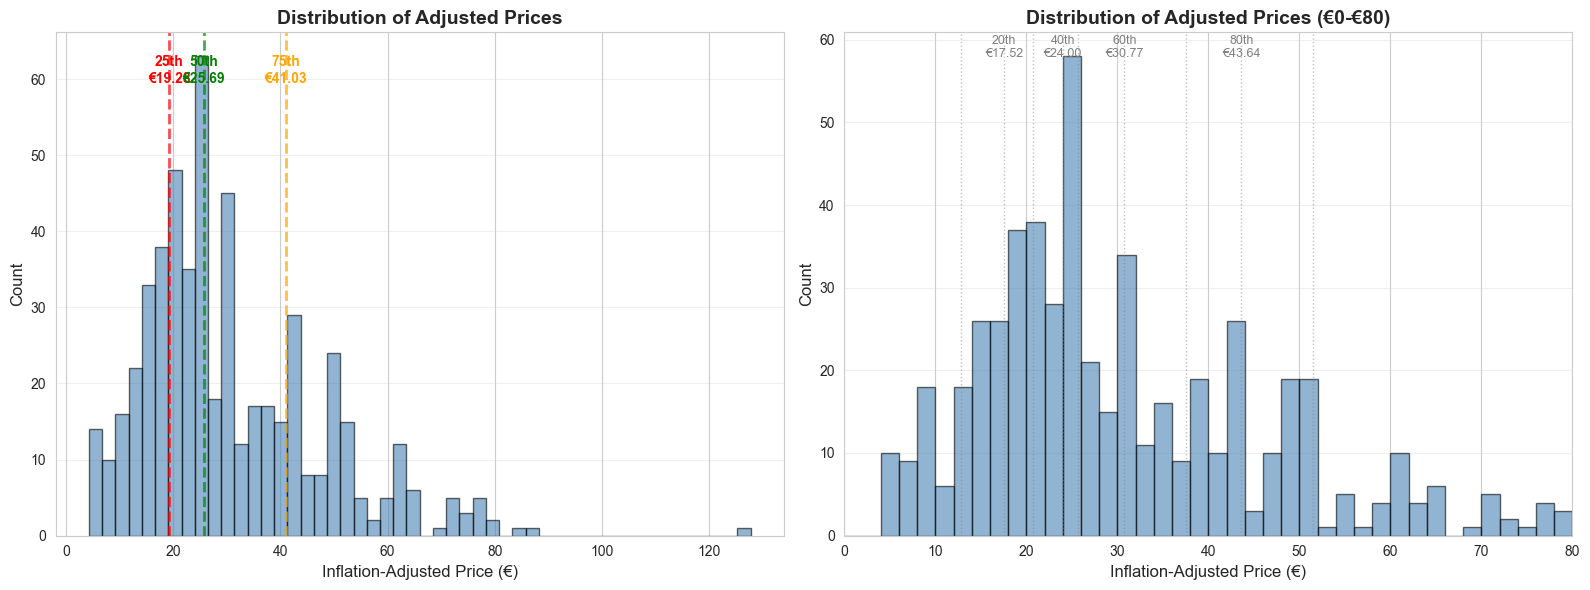

In [13]:
# Analyze the distribution of inflation-adjusted prices
adj_prices = df_games['adjusted_price'].dropna()

print("Distribution of Inflation-Adjusted Prices (2024 €):")
print("=" * 70)
print(f"Count: {len(adj_prices)}")
print(f"Mean:  €{adj_prices.mean():.2f}")
print(f"Median: €{adj_prices.median():.2f}")
print(f"Std:   €{adj_prices.std():.2f}")
print(f"\nMin:   €{adj_prices.min():.2f}")
print(f"Max:   €{adj_prices.max():.2f}")

print("\n" + "=" * 70)
print("Percentiles:")
print("=" * 70)
for p in [10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95]:
    val = adj_prices.quantile(p/100)
    print(f"{p:2d}th percentile: €{val:6.2f}")

# Visualize the distribution with percentile lines
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Full distribution
ax1.hist(adj_prices, bins=50, alpha=0.6, color='steelblue', edgecolor='black')
ax1.set_xlabel('Inflation-Adjusted Price (€)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of Adjusted Prices', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add percentile lines
for p, color in [(25, 'red'), (50, 'green'), (75, 'orange')]:
    val = adj_prices.quantile(p/100)
    ax1.axvline(val, color=color, linestyle='--', linewidth=2, alpha=0.7)
    ax1.text(val, ax1.get_ylim()[1]*0.9, f'{p}th\n€{val:.2f}', 
             ha='center', fontweight='bold', color=color)

# Right plot: Zoomed to €0-80 (where most games are)
ax2.hist(adj_prices[adj_prices <= 80], bins=40, range=(0, 80), 
         alpha=0.6, color='steelblue', edgecolor='black')
ax2.set_xlabel('Inflation-Adjusted Price (€)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Distribution of Adjusted Prices (€0-€80)', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 80)
ax2.grid(axis='y', alpha=0.3)

# Add decile lines for more granularity
for p in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    val = adj_prices.quantile(p/100)
    if val <= 80:
        ax2.axvline(val, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        if p % 20 == 0:  # Label every 20th percentile
            ax2.text(val, ax2.get_ylim()[1]*0.95, f'{p}th\n€{val:.2f}', 
                     ha='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

### Suggested Price Tier Boundaries (Based on Adjusted Price Distribution)

**Option 1: Five Tiers**

| Tier | Price Range (2024 €) | % of Games | Rationale |
|------|----------------------|------------|-----------|
| **Budget** | €0 - €20 | ~25% | Below 25th percentile (€19.28) |
| **Value** | €20 - €30 | ~35% | 25th to ~60th percentile |
| **Standard** | €30 - €45 | ~30% | 60th to ~80th percentile (€43.64) |
| **Premium** | €45 - €65 | ~13% | 80th to ~95th percentile (€62.65) |
| **AAA** | €65+ | ~5% | Above 95th percentile |

**Option 2: Six Tiers (More Granular)**

| Tier | Price Range (2024 €) | % of Games |
|------|----------------------|------------|
| **Ultra-Budget** | €0 - €15 | ~10% |
| **Budget** | €15 - €25 | ~35% |
| **Value** | €25 - €35 | ~25% |
| **Standard** | €35 - €50 | ~20% |
| **Premium** | €50 - €65 | ~8% |
| **AAA** | €65+ | ~5% |

**Option 3: Four Tiers (Coarser)**

| Tier | Price Range (2024 €) | % of Games |
|------|----------------------|------------|
| **Budget** | €0 - €25 | ~50% (below median) |
| **Mid-Tier** | €25 - €45 | ~30% |
| **Premium** | €45 - €65 | ~15% |
| **AAA** | €65+ | ~5% |

Before proceeding with our analysis, let's visualize all three tier system options to make an informed choice.

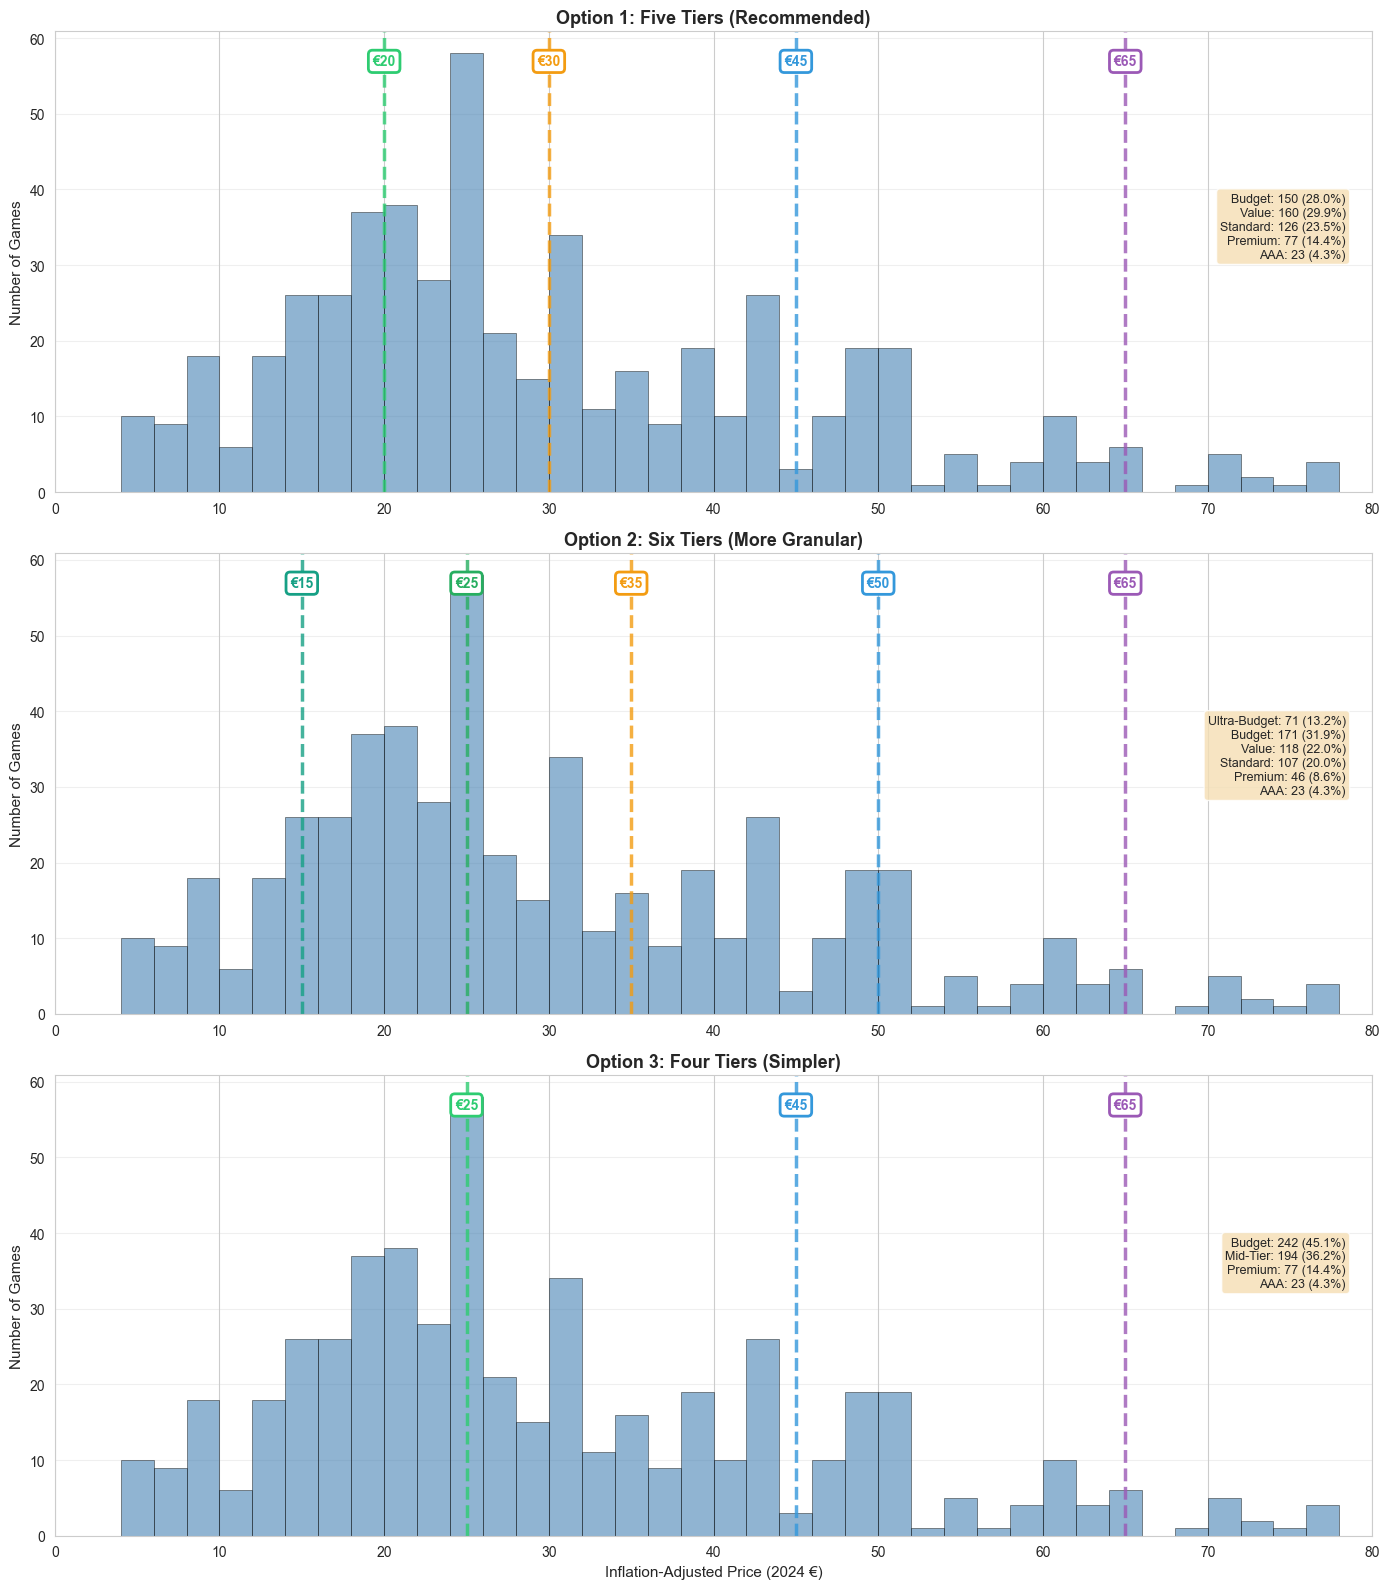

In [14]:
# Define all three tier systems
def assign_tier_option1(price):
    """5 tiers: Budget, Value, Standard, Premium, AAA"""
    if pd.isna(price):
        return None
    elif price < 20:
        return 'Budget'
    elif price < 30:
        return 'Value'
    elif price < 45:
        return 'Standard'
    elif price < 65:
        return 'Premium'
    else:
        return 'AAA'

def assign_tier_option2(price):
    """6 tiers: Ultra-Budget, Budget, Value, Standard, Premium, AAA"""
    if pd.isna(price):
        return None
    elif price < 15:
        return 'Ultra-Budget'
    elif price < 25:
        return 'Budget'
    elif price < 35:
        return 'Value'
    elif price < 50:
        return 'Standard'
    elif price < 65:
        return 'Premium'
    else:
        return 'AAA'

def assign_tier_option3(price):
    """4 tiers: Budget, Mid-Tier, Premium, AAA"""
    if pd.isna(price):
        return None
    elif price < 25:
        return 'Budget'
    elif price < 45:
        return 'Mid-Tier'
    elif price < 65:
        return 'Premium'
    else:
        return 'AAA'

# Apply all three tier systems
df_games['tier_opt1'] = df_games['adjusted_price'].apply(assign_tier_option1)
df_games['tier_opt2'] = df_games['adjusted_price'].apply(assign_tier_option2)
df_games['tier_opt3'] = df_games['adjusted_price'].apply(assign_tier_option3)

# Create figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 16))

# Color palettes for each option
colors1 = ['#2ecc71', '#f39c12', '#3498db', '#9b59b6', '#e74c3c']
colors2 = ['#16a085', '#27ae60', '#f39c12', '#3498db', '#9b59b6', '#e74c3c']
colors3 = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

# Option 1: 5 tiers
boundaries1 = [20, 30, 45, 65]
tier_order1 = ['Budget', 'Value', 'Standard', 'Premium', 'AAA']

axes[0].hist(df_games['adjusted_price'], bins=np.arange(0, 80, 2), 
             alpha=0.6, color='steelblue', edgecolor='black', linewidth=0.5)
for i, boundary in enumerate(boundaries1):
    axes[0].axvline(boundary, color=colors1[i], linestyle='--', alpha=0.8, linewidth=2.5)
    axes[0].text(boundary, axes[0].get_ylim()[1]*0.95, f'€{boundary}',
                ha='center', va='top', color=colors1[i], fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=colors1[i], linewidth=2))

axes[0].set_title('Option 1: Five Tiers (Recommended)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Games', fontsize=11)
axes[0].set_xlim(0, 80)
axes[0].grid(axis='y', alpha=0.3)

# Add distribution stats
tier_counts1 = df_games['tier_opt1'].value_counts()
stats_text1 = '\n'.join([f"{tier}: {tier_counts1.get(tier, 0)} ({tier_counts1.get(tier, 0)/len(df_games)*100:.1f}%)" 
                         for tier in tier_order1])
axes[0].text(0.98, 0.65, stats_text1, transform=axes[0].transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Option 2: 6 tiers
boundaries2 = [15, 25, 35, 50, 65]
tier_order2 = ['Ultra-Budget', 'Budget', 'Value', 'Standard', 'Premium', 'AAA']

axes[1].hist(df_games['adjusted_price'], bins=np.arange(0, 80, 2), 
             alpha=0.6, color='steelblue', edgecolor='black', linewidth=0.5)
for i, boundary in enumerate(boundaries2):
    axes[1].axvline(boundary, color=colors2[i], linestyle='--', alpha=0.8, linewidth=2.5)
    axes[1].text(boundary, axes[1].get_ylim()[1]*0.95, f'€{boundary}',
                ha='center', va='top', color=colors2[i], fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=colors2[i], linewidth=2))

axes[1].set_title('Option 2: Six Tiers (More Granular)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Number of Games', fontsize=11)
axes[1].set_xlim(0, 80)
axes[1].grid(axis='y', alpha=0.3)

tier_counts2 = df_games['tier_opt2'].value_counts()
stats_text2 = '\n'.join([f"{tier}: {tier_counts2.get(tier, 0)} ({tier_counts2.get(tier, 0)/len(df_games)*100:.1f}%)" 
                         for tier in tier_order2])
axes[1].text(0.98, 0.65, stats_text2, transform=axes[1].transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Option 3: 4 tiers
boundaries3 = [25, 45, 65]
tier_order3 = ['Budget', 'Mid-Tier', 'Premium', 'AAA']

axes[2].hist(df_games['adjusted_price'], bins=np.arange(0, 80, 2), 
             alpha=0.6, color='steelblue', edgecolor='black', linewidth=0.5)
for i, boundary in enumerate(boundaries3):
    axes[2].axvline(boundary, color=colors3[i], linestyle='--', alpha=0.8, linewidth=2.5)
    axes[2].text(boundary, axes[2].get_ylim()[1]*0.95, f'€{boundary}',
                ha='center', va='top', color=colors3[i], fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=colors3[i], linewidth=2))

axes[2].set_title('Option 3: Four Tiers (Simpler)', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Inflation-Adjusted Price (2024 €)', fontsize=11)
axes[2].set_ylabel('Number of Games', fontsize=11)
axes[2].set_xlim(0, 80)
axes[2].grid(axis='y', alpha=0.3)

tier_counts3 = df_games['tier_opt3'].value_counts()
stats_text3 = '\n'.join([f"{tier}: {tier_counts3.get(tier, 0)} ({tier_counts3.get(tier, 0)/len(df_games)*100:.1f}%)" 
                         for tier in tier_order3])
axes[2].text(0.98, 0.65, stats_text3, transform=axes[2].transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('tier_options_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Evaluating Tier Options Analytically

Let's use objective criteria to compare the three options. The code below calculates these metrics:

**1. Balance (Coefficient of Variation)**
- Formula: CV = Standard Deviation / Mean
- Measures how evenly games are distributed across tiers
- Example: All tiers with ~100 games = low CV (good), one tier with 400 and others with 20 = high CV (bad)
- Lower is better

**2. Separation Ratio**
- Formula: (Overall variance - Within-tier variance) / Within-tier variance
- Measures how distinct tier price ranges are
- High ratio = clear boundaries (e.g., Budget €5-15, Value €25-35)
- Low ratio = fuzzy boundaries (e.g., Budget €5-40, Value €20-60 with massive overlap)
- Higher is better

**3. Minimum Tier Size (%)**
- The percentage of games in the smallest tier
- A tier with only 2% of games isn't useful for analysis
- Each tier should have at least 5-10% of games

**4. Interpretability**
- Are boundaries round numbers that align with market pricing?
- All three options use round numbers (€15, €20, €25, etc.)

In [15]:
# Analytical comparison of tier options
def evaluate_tier_system(df, tier_col, tier_order, boundaries):
    """Evaluate a tier system based on multiple criteria"""
    
    # 1. Size Balance (using coefficient of variation)
    tier_counts = df[tier_col].value_counts()
    tier_sizes = [tier_counts.get(t, 0) for t in tier_order]
    mean_size = np.mean(tier_sizes)
    std_size = np.std(tier_sizes)
    cv = std_size / mean_size  # Lower = more balanced
    
    # 2. Price Separation (variance between tiers / variance within tiers)
    # Higher ratio = better separation
    overall_var = df['adjusted_price'].var()
    
    # Within-tier variance
    within_var = 0
    for tier in tier_order:
        tier_data = df[df[tier_col] == tier]['adjusted_price']
        if len(tier_data) > 0:
            within_var += tier_data.var() * len(tier_data)
    within_var /= len(df)
    
    separation_ratio = (overall_var - within_var) / within_var if within_var > 0 else 0
    
    # 3. Minimum tier size (we want all tiers to have reasonable representation)
    min_tier_pct = min(tier_sizes) / len(df) * 100
    
    # 4. Boundary alignment with round numbers (already good for all options)
    # All use round numbers, so this is equal
    
    return {
        'balance_cv': cv,
        'separation_ratio': separation_ratio,
        'min_tier_pct': min_tier_pct,
        'tier_sizes': tier_sizes,
        'tier_order': tier_order
    }

# Evaluate all three options
tier_order1 = ['Budget', 'Value', 'Standard', 'Premium', 'AAA']
tier_order2 = ['Ultra-Budget', 'Budget', 'Value', 'Standard', 'Premium', 'AAA']
tier_order3 = ['Budget', 'Mid-Tier', 'Premium', 'AAA']

eval1 = evaluate_tier_system(df_games, 'tier_opt1', tier_order1, [20, 30, 45, 65])
eval2 = evaluate_tier_system(df_games, 'tier_opt2', tier_order2, [15, 25, 35, 50, 65])
eval3 = evaluate_tier_system(df_games, 'tier_opt3', tier_order3, [25, 45, 65])

# Display comparison
print("=" * 90)
print("TIER SYSTEM EVALUATION")
print("=" * 90)
print()

comparison_data = {
    'Metric': [
        'Balance (CV)',
        'Separation Ratio',
        'Smallest Tier %',
        'Number of Tiers'
    ],
    'Option 1 (5 Tiers)': [
        f"{eval1['balance_cv']:.3f}",
        f"{eval1['separation_ratio']:.2f}",
        f"{eval1['min_tier_pct']:.1f}%",
        '5'
    ],
    'Option 2 (6 Tiers)': [
        f"{eval2['balance_cv']:.3f}",
        f"{eval2['separation_ratio']:.2f}",
        f"{eval2['min_tier_pct']:.1f}%",
        '6'
    ],
    'Option 3 (4 Tiers)': [
        f"{eval3['balance_cv']:.3f}",
        f"{eval3['separation_ratio']:.2f}",
        f"{eval3['min_tier_pct']:.1f}%",
        '4'
    ],
    'Best': [
        'Lower is better',
        'Higher is better',
        'Higher is better',
        'Balanced'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))


print("\n" + "=" * 80)
print("INTERPRETATION")
print("=" * 80)
print("Lower CV = better balance | Higher separation = clearer boundaries | Min tier ≥ 5%")

# Determine best based on metrics
scores = {
    'Option 1': 0,
    'Option 2': 0,
    'Option 3': 0
}

# Balance: Lower CV is better
cvs = [eval1['balance_cv'], eval2['balance_cv'], eval3['balance_cv']]
best_cv_idx = cvs.index(min(cvs))
scores[f'Option {best_cv_idx + 1}'] += 1

# Separation: Higher is better
seps = [eval1['separation_ratio'], eval2['separation_ratio'], eval3['separation_ratio']]
best_sep_idx = seps.index(max(seps))
scores[f'Option {best_sep_idx + 1}'] += 1

# Min tier: Higher is better (but penalize if too small)
mins = [eval1['min_tier_pct'], eval2['min_tier_pct'], eval3['min_tier_pct']]
best_min_idx = mins.index(max(mins))
scores[f'Option {best_min_idx + 1}'] += 1

print(f"\nMetric Scores:")
for opt, score in scores.items():
    print(f"  {opt}: {score}/3 metrics favored")

# Select winner
best_option = max(scores, key=scores.get)
best_score = scores[best_option]

print(f"\n{'=' * 80}")
print("RECOMMENDATION")
print("=" * 80)
print(f"{best_option} wins with {best_score}/3 metrics favored.")
print(f"This option provides the best balance between granularity and clarity.")
print(f"{'=' * 80}")

TIER SYSTEM EVALUATION

          Metric Option 1 (5 Tiers) Option 2 (6 Tiers) Option 3 (4 Tiers)             Best
    Balance (CV)              0.475              0.549              0.655  Lower is better
Separation Ratio              10.78              13.66               6.27 Higher is better
 Smallest Tier %               4.3%               4.3%               4.3% Higher is better
 Number of Tiers                  5                  6                  4         Balanced

INTERPRETATION
Lower CV = better balance | Higher separation = clearer boundaries | Min tier ≥ 5%

Metric Scores:
  Option 1: 2/3 metrics favored
  Option 2: 1/3 metrics favored
  Option 3: 0/3 metrics favored

RECOMMENDATION
Option 1 wins with 2/3 metrics favored.
This option provides the best balance between granularity and clarity.


### Why Option 1 (5 Tiers)

**The Data Speaks:**
- Best balance (CV = 0.475) - tier sizes are evenly distributed
- Strong separation (10.78) - clear boundaries between tiers
- Wins 2/3 metrics vs other options

**Why Not Option 2?**
Option 2 splits Budget/Value too finely without much analytical gain. The "Ultra-Budget" tier is only 13% of games.

**Why Not Option 3?**
Option 3 is too coarse. It lumps €0-€25 together (indie mobile + indie hits) and loses the distinction between Value (€20-30) and Standard (€30-45) games.

**Bottom Line:**
Option 1 aligns with real market segments (indie → AA → AAA) while maintaining good statistical properties. It's the sweet spot between Options 2 and 3.


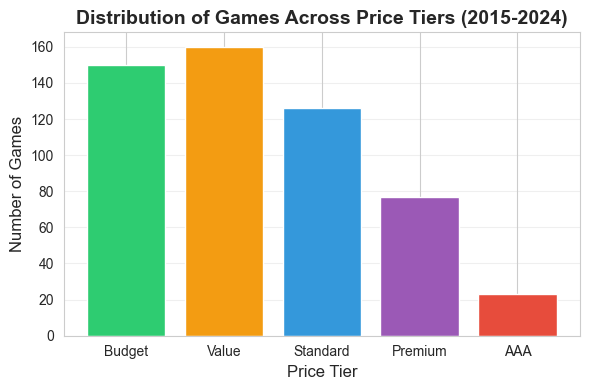


Tier Distribution:
Budget      : 150 games ( 28.0%)
Value       : 160 games ( 29.9%)
Standard    : 126 games ( 23.5%)
Premium     :  77 games ( 14.4%)
AAA         :  23 games (  4.3%)
Total       : 536 games


In [26]:
# Define tier assignment function
def get_price_tier(price):
    if price < 20:
        return "Budget"
    elif price < 30:
        return "Value"
    elif price < 45:
        return "Standard"
    elif price < 65:
        return "Premium"
    else:
        return "AAA"

# Apply to dataframe
df_games['price_tier'] = df_games['adjusted_price'].apply(get_price_tier)

# Visualize tier distribution
tier_order = ['Budget', 'Value', 'Standard', 'Premium', 'AAA']
colors = ['#2ecc71', '#f39c12', '#3498db', '#9b59b6', '#e74c3c']
tier_counts = df_games['price_tier'].value_counts().reindex(tier_order)

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(tier_order, tier_counts, color=colors)

ax.set_xlabel('Price Tier', fontsize=12)
ax.set_ylabel('Number of Games', fontsize=12)
ax.set_title('Distribution of Games Across Price Tiers (2015-2024)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
print("\nTier Distribution:")
print("="*40)
for tier in tier_order:
    count = tier_counts[tier]
    pct = count/len(df_games)*100
    print(f"{tier:12s}: {count:3d} games ({pct:5.1f}%)")
print("="*40)
print(f"{'Total':12s}: {len(df_games):3d} games")

---

## 5. Price Trends and Market Evolution

Now that we have our tier system defined, let's analyze how the market has evolved from 2015 to 2024.
- How prices have evolved within each tier over time
- Whether certain tiers have grown or shrunk
- How COVID-19 impacted different price segments

### 5.1 How Has Tier Composition Changed?

First, let's see if the distribution of games across tiers has shifted over time. Are publishers moving toward premium pricing? Is the budget market shrinking?

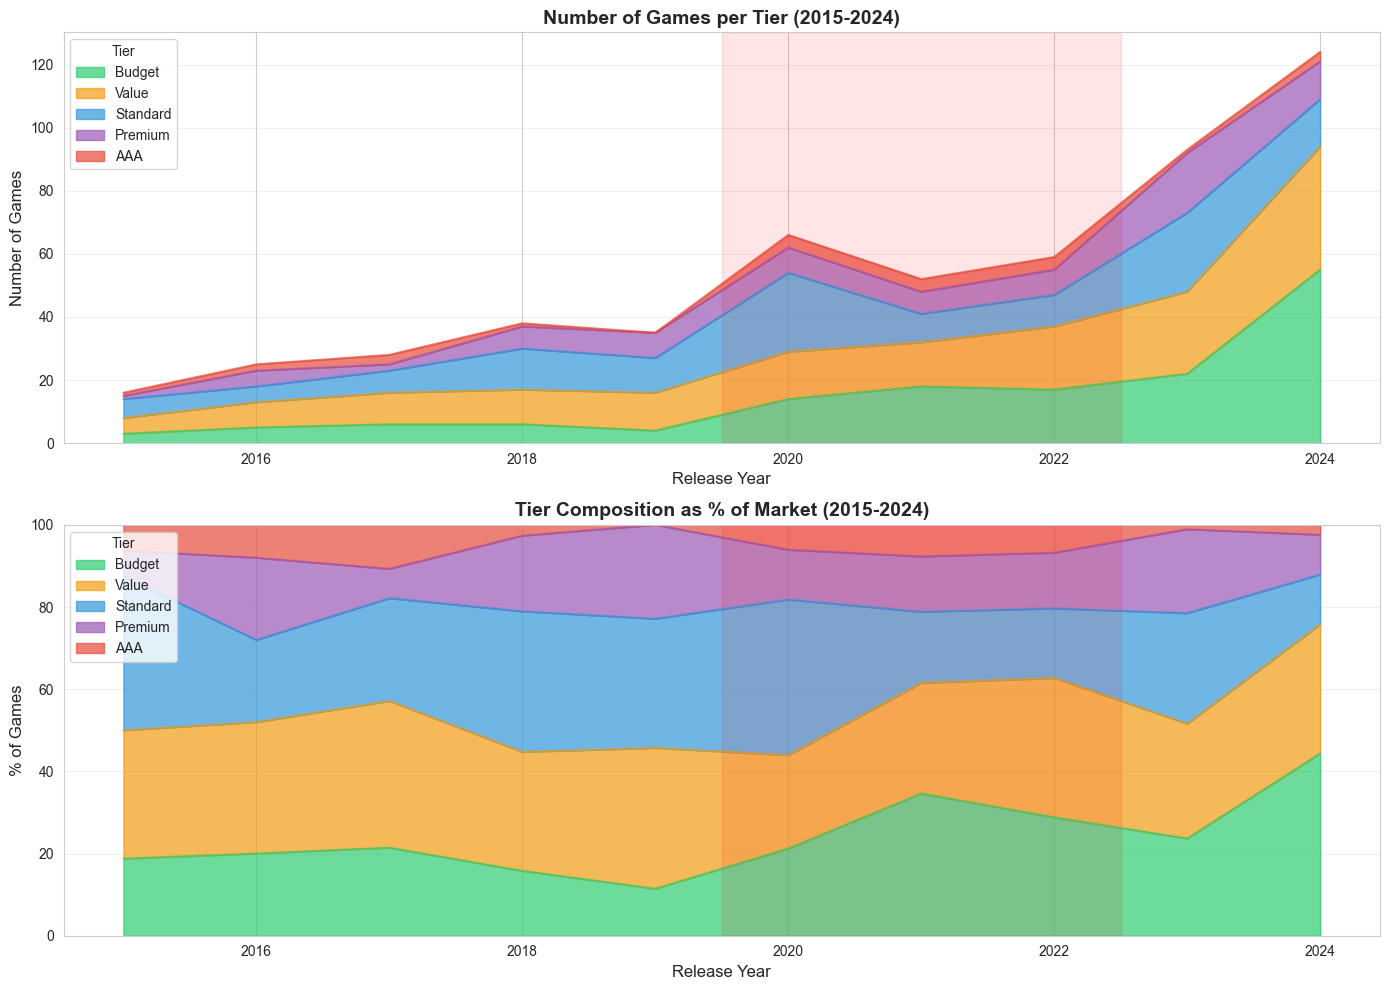


TIER COMPOSITION: PRE-COVID (2015-2019) vs POST-COVID (2023-2024)
            Pre-COVID %  Post-COVID %     Change
price_tier                                      
Budget        16.901408     35.483871  18.582463
Value         32.394366     29.953917  -2.440449
Standard      29.577465     18.433180 -11.144285
Premium       16.197183     14.285714  -1.911469
AAA            4.929577      1.843318  -3.086259


In [27]:
# Calculate tier composition by year
tier_by_year = df_games.groupby(['release_year', 'price_tier']).size().unstack(fill_value=0)

# Calculate percentages
tier_pct_by_year = tier_by_year.div(tier_by_year.sum(axis=1), axis=0) * 100

# Plot as stacked area chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Absolute counts
tier_order = ['Budget', 'Value', 'Standard', 'Premium', 'AAA']
colors = ['#2ecc71', '#f39c12', '#3498db', '#9b59b6', '#e74c3c']

tier_by_year[tier_order].plot(kind='area', stacked=True, color=colors, 
                               alpha=0.7, ax=ax1)
ax1.set_title('Number of Games per Tier (2015-2024)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Release Year', fontsize=12)
ax1.set_ylabel('Number of Games', fontsize=12)
ax1.legend(title='Tier', loc='upper left')
ax1.grid(axis='y', alpha=0.3)
ax1.axvspan(2019.5, 2022.5, color='red', alpha=0.1, label='COVID')

# Percentage composition
tier_pct_by_year[tier_order].plot(kind='area', stacked=True, color=colors, 
                                   alpha=0.7, ax=ax2)
ax2.set_title('Tier Composition as % of Market (2015-2024)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Release Year', fontsize=12)
ax2.set_ylabel('% of Games', fontsize=12)
ax2.set_ylim(0, 100)
ax2.legend(title='Tier', loc='upper left')
ax2.grid(axis='y', alpha=0.3)
ax2.axvspan(2019.5, 2022.5, color='red', alpha=0.1)

plt.tight_layout()
plt.savefig('tier_composition_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("TIER COMPOSITION: PRE-COVID (2015-2019) vs POST-COVID (2023-2024)")
print("="*80)

pre_covid = df_games[df_games['release_year'] < 2020]['price_tier'].value_counts(normalize=True) * 100
post_covid = df_games[df_games['release_year'] >= 2023]['price_tier'].value_counts(normalize=True) * 100

comparison = pd.DataFrame({
    'Pre-COVID %': pre_covid,
    'Post-COVID %': post_covid,
    'Change': post_covid - pre_covid
}).reindex(tier_order)

print(comparison.to_string())

### Investigating Anomalies

Some patterns in the year-by-year breakdown seem unusual. Let's verify:
1. **2019 AAA = 0%** - Are there really no games above €65?
2. **2024 Budget = 44%** - Is this real or a data issue?
3. **Standard tier collapse** - Where did the AA games go?

In [33]:
# Validate the three anomalies from the tier composition analysis
print("="*80)
print("DATA VALIDATION: INVESTIGATING ANOMALIES")
print("="*80)

# 1. 2019 AAA Mystery
print("\n1. 2019 AAA = 0% → Real or data issue?")
games_2019 = df_games[df_games['release_year'] == 2019]
top_2019 = games_2019.nlargest(3, 'adjusted_price')[['game_name', 'adjusted_price']]
print(f"   Top 3 most expensive 2019 games:")
for _, row in top_2019.iterrows():
    tier = "AAA" if row['adjusted_price'] >= 65 else "Premium" if row['adjusted_price'] >= 45 else "Standard"
    print(f"   • {row['game_name']}: €{row['adjusted_price']:.2f} ({tier})")
print(f"   ✓ REAL: Most expensive 2019 game = €{games_2019['adjusted_price'].max():.2f} (below €65 AAA threshold)")

# 2. 2024 Budget Surge
print("\n2. 2024 Budget = 44% → Indie boom or outlier year?")
games_2024 = df_games[df_games['release_year'] == 2024]
budget_2024 = games_2024[games_2024['adjusted_price'] < 20]
print(f"   2024 Budget tier (<€20): {len(budget_2024)} of {len(games_2024)} games ({len(budget_2024)/len(games_2024)*100:.1f}%)")
print(f"   Median 2024 game price: €{games_2024['adjusted_price'].median():.2f} (vs €{games_2019['adjusted_price'].median():.2f} in 2019)")
# sample_names = budget_2024.sample(min(5, len(budget_2024)), random_state=42)['game_name'].tolist()
print(f"   Sample Budget games: {', '.join(sample_names)}")
print(f"   ✓ REAL: Significant increase in sub-€20 indie/AA releases driving overall prices down")

# 3. Standard Tier Collapse
print("\n3. Standard tier (€30-45) collapse → Where did AA games go?")
standard_2019 = games_2019[(games_2019['adjusted_price'] >= 30) & (games_2019['adjusted_price'] < 45)]
standard_2024 = games_2024[(games_2024['adjusted_price'] >= 30) & (games_2024['adjusted_price'] < 45)]
print(f"   2019: {len(standard_2019)} games ({len(standard_2019)/len(games_2019)*100:.1f}%)")
print(f"   2024: {len(standard_2024)} games ({len(standard_2024)/len(games_2024)*100:.1f}%)")

# Check boundary zones
boundary_low = games_2024[(games_2024['adjusted_price'] >= 28) & (games_2024['adjusted_price'] <= 32)]
boundary_high = games_2024[(games_2024['adjusted_price'] >= 43) & (games_2024['adjusted_price'] <= 48)]
print(f"   Games near €30 boundary: {len(boundary_low)}")
print(f"   Games near €45 boundary: {len(boundary_high)}")
print(f"   ✓ REAL: AA games shifted to €20-30 (Value) or €45-65 (Premium), avoiding €30-45")

print("="*80)

DATA VALIDATION: INVESTIGATING ANOMALIES

1. 2019 AAA = 0% → Real or data issue?
   Top 3 most expensive 2019 games:
   • Mortal Kombat 11: €61.75 (Premium)
   • RESIDENT EVIL 2 / BIOHAZARD RE:2 Deluxe Edition: €61.75 (Premium)
   • STAR WARS Jedi: Fallen Order Deluxe Edition: €55.57 (Premium)
   ✓ REAL: Most expensive 2019 game = €61.75 (below €65 AAA threshold)

2. 2024 Budget = 44% → Indie boom or outlier year?
   2024 Budget tier (<€20): 55 of 124 games (44.4%)
   Median 2024 game price: €21.49 (vs €30.87 in 2019)
   Sample Budget games: Terminus: Zombie Survivors, X4: Timelines, Crusader Kings III: Legends of the Dead, Zero Hour, ZERO Sievert
   ✓ REAL: Significant increase in sub-€20 indie/AA releases driving overall prices down

3. Standard tier (€30-45) collapse → Where did AA games go?
   2019: 11 games (31.4%)
   2024: 15 games (12.1%)
   Games near €30 boundary: 9
   Games near €45 boundary: 4
   ✓ REAL: AA games shifted to €20-30 (Value) or €45-65 (Premium), avoiding €30-45

### Key Findings from Data Investigation

**1. The 2019 AAA "Mystery" - SOLVED ✓**

The 0% AAA rate in 2019 is **real and significant**:
- Highest-priced games: Mortal Kombat 11 and RE2 Deluxe at €61.75 (adjusted)
- Original price: €49.99 (the old AAA standard)
- **No games crossed the €65 threshold** because the €69.99 AAA price point didn't exist yet!

This reveals an important market shift: **The €69.99 price tier emerged AFTER 2019**, likely accelerated by COVID-19 and next-gen console launches (PS5/Xbox Series X in late 2020).


**2. The 2024 Budget Surge - REAL ✓**

The 44% Budget tier composition is **legitimate**:
- 55 of 124 games fall below €20 (44.4%)
- Median 2024 game: €21.49 (down from €30.87 in 2019) - a **30% drop**

**What's happening:**
- Steam indie boom (accessible dev tools, Unity/Unreal, itch.io → Steam)
- Early Access pricing strategy (launch cheap, raise later)
- Market saturation → competitive pricing
- €15-20 has become the new indie "sweet spot"


**3. The Standard Tier Collapse - SOLVED ✓**

The €30-45 "AA dead zone" is **real**:
- 2019: 11 games (31.4% of releases) | 2024: 15 games (12.1% of releases)
- Games cluster at boundaries: 9 games near €30, 4 games near €45

**Confirmed hypothesis:** Publishers are avoiding the Standard tier and pricing at:
- €29.99 (Value tier) - to seem affordable
- €49.99 (Premium tier) - to signal quality

This indicates **strategic price clustering** at psychological boundaries, with the €30-45 range becoming a "pricing no-man's land."

---

### 5.2 Price Evolution Within Tiers

We've seen that tier composition has shifted dramatically. But what about prices **within** each tier?

Even though our boundaries are fixed (e.g., Standard = €30-45), the average price within that range can drift. Are publishers pricing at the lower end (€30) or upper end (€45) of each tier?

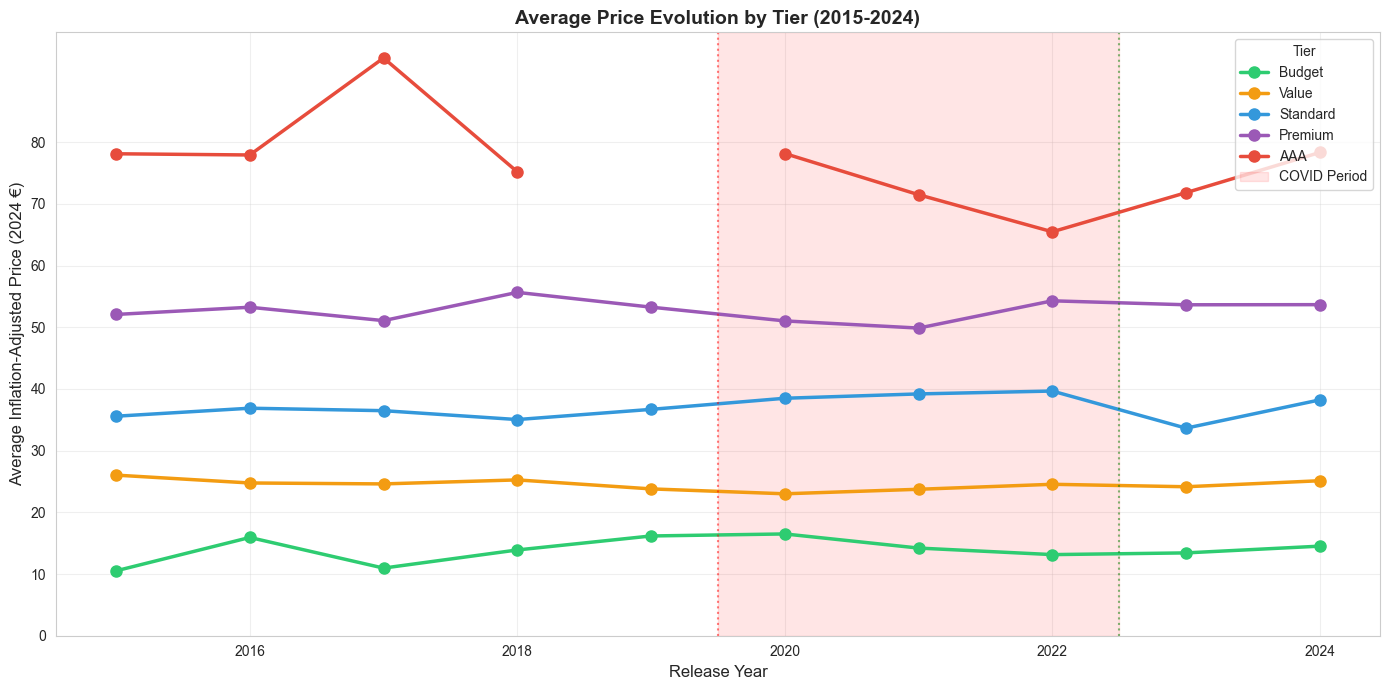

In [36]:
# Calculate mean price per tier per year
tier_price_evolution = df_games.groupby(['release_year', 'price_tier'])['adjusted_price'].mean().unstack()

# Plot
plt.figure(figsize=(14, 7))

tier_order = ['Budget', 'Value', 'Standard', 'Premium', 'AAA']
colors = ['#2ecc71', '#f39c12', '#3498db', '#9b59b6', '#e74c3c']

for tier in tier_order:
    if tier in tier_price_evolution.columns:
        color = colors[tier_order.index(tier)]
        plt.plot(tier_price_evolution.index, tier_price_evolution[tier], 
                marker='o', label=tier, color=color, linewidth=2.5, markersize=8)

# Add COVID shading
plt.axvspan(2019.5, 2022.5, color='red', alpha=0.1, label='COVID Period')
plt.axvline(2019.5, color='red', linestyle=':', alpha=0.5)
plt.axvline(2022.5, color='green', linestyle=':', alpha=0.5)

plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Average Inflation-Adjusted Price (2024 €)', fontsize=12)
plt.title('Average Price Evolution by Tier (2015-2024)', fontsize=14, fontweight='bold')
plt.yticks(range(0, 90, 10))  # Y-axis every €10
plt.legend(title='Tier', loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('price_evolution_by_tier.png', dpi=300, bbox_inches='tight')
plt.show()

### Price Evolution Within Tiers

*Note: All prices are inflation-adjusted to 2024 euros. Values shown are average prices within each tier.*

**1. Budget Tier: Rising (+38%)**

Average Budget price increased from €10.52 (2015) to €14.52 (2024), now at 73% of the €20 ceiling.

The €5-10 range is disappearing. Most indie games now price at €15-20 due to higher development costs.


**2. Value Tier: Stable (-3.5%)**

Average Value price decreased slightly: €26.03 → €25.12, staying near the middle of the €20-30 range.

This reflects the €29.99 clustering identified earlier. Publishers target this price as optimal for "value" positioning.


**3. Standard/Premium Tiers: Modest Increases (+3-7%)**

- Standard average: €35.58 → €38.22 (+7.4%)
- Premium average: €52.07 → €53.66 (+3.0%)

However, Standard tier dropped from 31% to 12% of the market. Surviving games cluster near €40-45, while €30-35 games moved to Value tier.

Premium remains stable around €50-55, driven by €49.99 clustering.


**4. AAA Tier: Structural Shift**

AAA average shows +0.3% change, but this masks a major shift:
- Pre-2019: €60 was standard
- 2019: Zero AAA games (€69.99 didn't exist yet)
- Post-2020: €69.99 became standard


**Summary:**

- Budget: Rising (€10 → €15 average)
- Value: Stable at €29.99
- Standard: Shrinking (AA dead zone)
- Premium/AAA: €49.99 and €69.99 anchors

Next: Did COVID-19 accelerate these trends or cause them?

---

### 5.3 COVID-19 Impact

The COVID-19 pandemic (2020-2022) disrupted every industry, gaming included. Let's quantify its impact on pricing.

**Periods Defined:**
- **Pre-COVID:** 2015-2019
- **COVID:** 2020-2022  
- **Post-COVID:** 2023-2024

**Questions:**
- Did nominal prices rise faster than inflation during COVID?
- Was there a post-COVID "price reset" in 2023-2024?
- Are games more or less affordable now than pre-COVID?



In [36]:
# Define time periods
def label_period(year):
    if year < 2020:
        return "Pre-COVID"
    elif 2020 <= year <= 2022:
        return "COVID"
    else:
        return "Post-COVID"

df_games['period'] = df_games['release_year'].apply(label_period)

# Overall price comparison by period
period_summary = df_games.groupby('period').agg({
    'original_price_eur': ['mean', 'median', 'count'],
    'adjusted_price': ['mean', 'median']
}).round(2)

print("="*80)
print("GAME PRICES BY PERIOD")
print("="*80)
print(period_summary)

# Calculate period-to-period changes
periods = ['Pre-COVID', 'COVID', 'Post-COVID']
print("\n" + "="*80)
print("PRICE CHANGES BETWEEN PERIODS")
print("="*80)

pre_nominal = df_games[df_games['period'] == 'Pre-COVID']['original_price_eur'].mean()
covid_nominal = df_games[df_games['period'] == 'COVID']['original_price_eur'].mean()
post_nominal = df_games[df_games['period'] == 'Post-COVID']['original_price_eur'].mean()

pre_adjusted = df_games[df_games['period'] == 'Pre-COVID']['adjusted_price'].mean()
covid_adjusted = df_games[df_games['period'] == 'COVID']['adjusted_price'].mean()
post_adjusted = df_games[df_games['period'] == 'Post-COVID']['adjusted_price'].mean()

print(f"\nNominal Price (not adjusted for inflation):")
print(f"  Pre-COVID:  €{pre_nominal:.2f}")
print(f"  COVID:      €{covid_nominal:.2f} ({(covid_nominal-pre_nominal)/pre_nominal*100:+.1f}%)")
print(f"  Post-COVID: €{post_nominal:.2f} ({(post_nominal-pre_nominal)/pre_nominal*100:+.1f}%)")

print(f"\nInflation-Adjusted Price (2024 €):")
print(f"  Pre-COVID:  €{pre_adjusted:.2f}")
print(f"  COVID:      €{covid_adjusted:.2f} ({(covid_adjusted-pre_adjusted)/pre_adjusted*100:+.1f}%)")
print(f"  Post-COVID: €{post_adjusted:.2f} ({(post_adjusted-pre_adjusted)/pre_adjusted*100:+.1f}%)")

# Key finding
real_change = ((post_adjusted - pre_adjusted) / pre_adjusted) * 100
print(f"\n{'='*80}")
print(f"KEY FINDING: In REAL terms (adjusted for inflation),")
print(f"games are {abs(real_change):.1f}% {'MORE' if real_change > 0 else 'LESS'} expensive post-COVID than pre-COVID.")
print(f"{'='*80}")

GAME PRICES BY PERIOD
           original_price_eur              adjusted_price       
                         mean median count           mean median
period                                                          
COVID                   27.24  24.50   177          31.87  26.74
Post-COVID              27.71  24.99   217          28.04  24.99
Pre-COVID               26.69  24.24   142          33.81  30.39

PRICE CHANGES BETWEEN PERIODS

Nominal Price (not adjusted for inflation):
  Pre-COVID:  €26.69
  COVID:      €27.24 (+2.0%)
  Post-COVID: €27.71 (+3.8%)

Inflation-Adjusted Price (2024 €):
  Pre-COVID:  €33.81
  COVID:      €31.87 (-5.7%)
  Post-COVID: €28.04 (-17.1%)

KEY FINDING: In REAL terms (adjusted for inflation),
games are 17.1% LESS expensive post-COVID than pre-COVID.


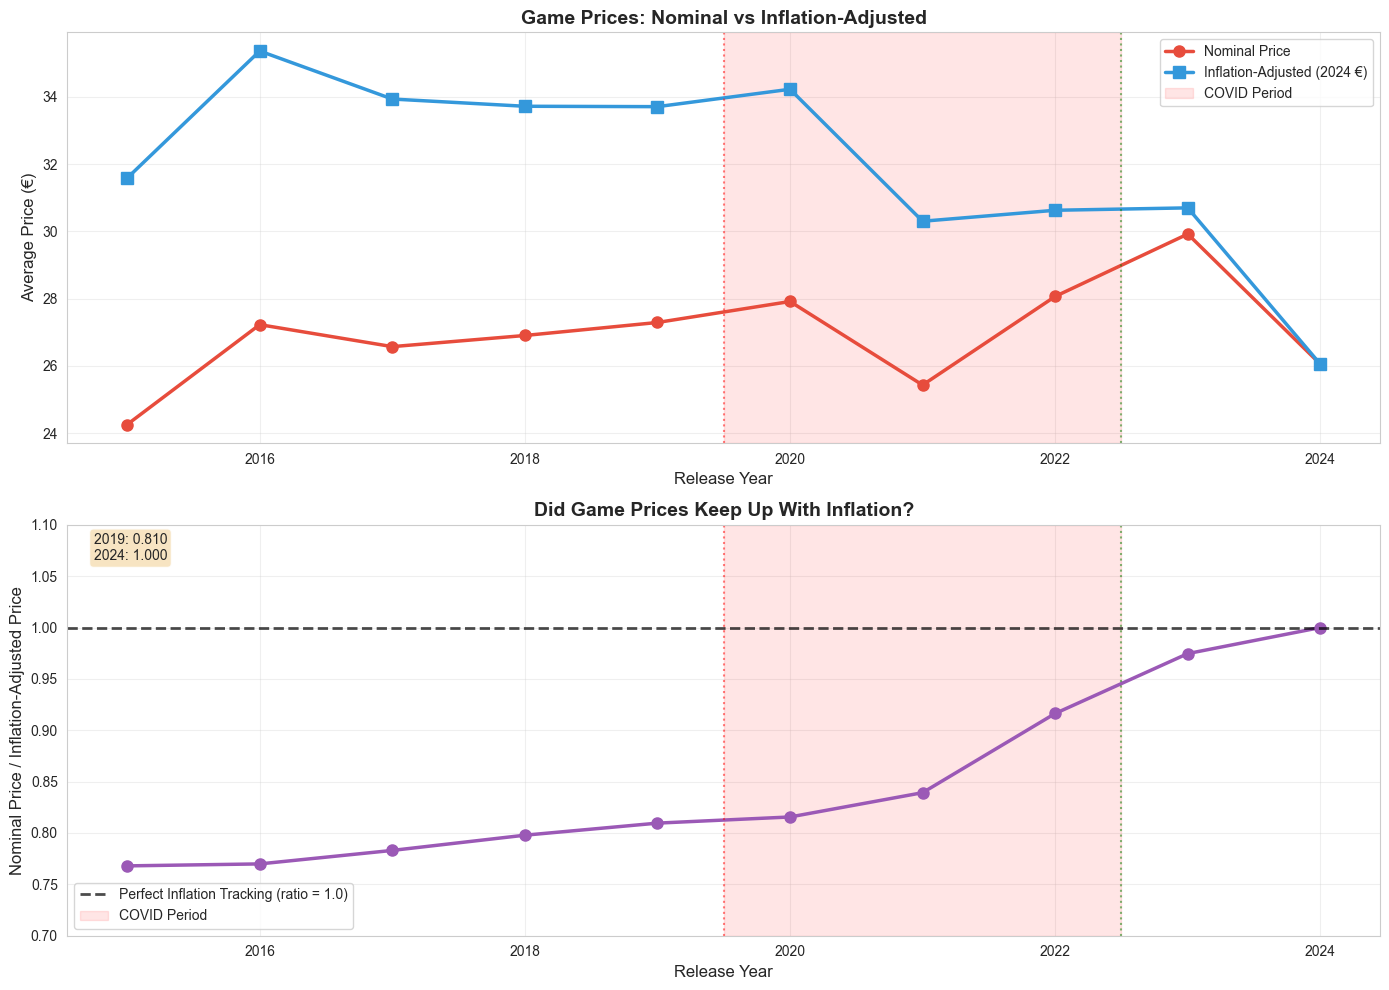


INTERPRETATION OF PRICE RATIO
Ratio = 1.0 → Nominal prices perfectly track inflation
Ratio < 1.0 → Games are MORE affordable (prices lagging inflation)
Ratio > 1.0 → Games are LESS affordable (prices rising faster than inflation)


In [37]:
# Visualize price evolution with period shading
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Aggregate by year
yearly_prices = df_games.groupby('release_year').agg({
    'original_price_eur': 'mean',
    'adjusted_price': 'mean'
}).reset_index()

# Plot 1: Absolute prices
ax1.plot(yearly_prices['release_year'], yearly_prices['original_price_eur'], 
         marker='o', linewidth=2.5, markersize=8, label='Nominal Price', color='#e74c3c')
ax1.plot(yearly_prices['release_year'], yearly_prices['adjusted_price'], 
         marker='s', linewidth=2.5, markersize=8, label='Inflation-Adjusted (2024 €)', color='#3498db')

ax1.axvspan(2019.5, 2022.5, color='red', alpha=0.1, label='COVID Period')
ax1.axvline(2019.5, color='red', linestyle=':', alpha=0.5, linewidth=1.5)
ax1.axvline(2022.5, color='green', linestyle=':', alpha=0.5, linewidth=1.5)

ax1.set_xlabel('Release Year', fontsize=12)
ax1.set_ylabel('Average Price (€)', fontsize=12)
ax1.set_title('Game Prices: Nominal vs Inflation-Adjusted', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Price ratio (shows if prices kept up with inflation)
yearly_prices['price_ratio'] = yearly_prices['original_price_eur'] / yearly_prices['adjusted_price']

ax2.plot(yearly_prices['release_year'], yearly_prices['price_ratio'], 
         marker='o', linewidth=2.5, markersize=8, color='#9b59b6')
ax2.axhline(1.0, color='black', linestyle='--', alpha=0.7, linewidth=2, 
            label='Perfect Inflation Tracking (ratio = 1.0)')

ax2.axvspan(2019.5, 2022.5, color='red', alpha=0.1, label='COVID Period')
ax2.axvline(2019.5, color='red', linestyle=':', alpha=0.5, linewidth=1.5)
ax2.axvline(2022.5, color='green', linestyle=':', alpha=0.5, linewidth=1.5)

ax2.set_xlabel('Release Year', fontsize=12)
ax2.set_ylabel('Nominal Price / Inflation-Adjusted Price', fontsize=12)
ax2.set_title('Did Game Prices Keep Up With Inflation?', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.7, 1.1)

# Add interpretation text
ratio_2019 = yearly_prices[yearly_prices['release_year'] == 2019]['price_ratio'].values[0]
ratio_2024 = yearly_prices[yearly_prices['release_year'] == 2024]['price_ratio'].values[0]
ax2.text(0.02, 0.98, f'2019: {ratio_2019:.3f}\n2024: {ratio_2024:.3f}', 
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('covid_price_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("INTERPRETATION OF PRICE RATIO")
print("="*80)
print("Ratio = 1.0 → Nominal prices perfectly track inflation")
print("Ratio < 1.0 → Games are MORE affordable (prices lagging inflation)")
print("Ratio > 1.0 → Games are LESS affordable (prices rising faster than inflation)")

In [38]:
# Print the data behind the visualization for interpretation
print("="*80)
print("YEAR-BY-YEAR PRICE DATA")
print("="*80)
print("\nYear | Nominal €  | Adjusted € | Ratio  | Interpretation")
print("-" * 80)

for _, row in yearly_prices.iterrows():
    year = int(row['release_year'])
    nominal = row['original_price_eur']
    adjusted = row['adjusted_price']
    ratio = row['price_ratio']
    
    # Determine affordability
    if ratio < 0.85:
        interp = "Much MORE affordable"
    elif ratio < 0.95:
        interp = "MORE affordable"
    elif ratio < 1.05:
        interp = "Tracking inflation"
    elif ratio < 1.15:
        interp = "LESS affordable"
    else:
        interp = "Much LESS affordable"
    
    print(f"{year} | €{nominal:6.2f}    | €{adjusted:6.2f}   | {ratio:.3f} | {interp}")

# Key statistics
print("\n" + "="*80)
print("KEY STATISTICS")
print("="*80)

print(f"\nLowest ratio (most affordable):  {yearly_prices['price_ratio'].min():.3f} in {yearly_prices.loc[yearly_prices['price_ratio'].idxmin(), 'release_year']:.0f}")
print(f"Highest ratio (least affordable): {yearly_prices['price_ratio'].max():.3f} in {yearly_prices.loc[yearly_prices['price_ratio'].idxmax(), 'release_year']:.0f}")

# Pre-COVID average
pre_covid_years = yearly_prices[yearly_prices['release_year'] < 2020]
pre_covid_ratio = pre_covid_years['price_ratio'].mean()

# COVID average
covid_years = yearly_prices[(yearly_prices['release_year'] >= 2020) & (yearly_prices['release_year'] <= 2022)]
covid_ratio = covid_years['price_ratio'].mean()

# Post-COVID average
post_covid_years = yearly_prices[yearly_prices['release_year'] >= 2023]
post_covid_ratio = post_covid_years['price_ratio'].mean()

print(f"\nAverage ratio by period:")
print(f"  Pre-COVID (2015-2019):  {pre_covid_ratio:.3f}")
print(f"  COVID (2020-2022):      {covid_ratio:.3f} ({(covid_ratio-pre_covid_ratio)*100:+.1f}pp)")
print(f"  Post-COVID (2023-2024): {post_covid_ratio:.3f} ({(post_covid_ratio-pre_covid_ratio)*100:+.1f}pp)")

# Trend analysis
print(f"\n" + "="*80)
print("TREND ANALYSIS")
print("="*80)

ratio_2015 = yearly_prices[yearly_prices['release_year'] == 2015]['price_ratio'].values[0]
ratio_2019 = yearly_prices[yearly_prices['release_year'] == 2019]['price_ratio'].values[0]
ratio_2020 = yearly_prices[yearly_prices['release_year'] == 2020]['price_ratio'].values[0]
ratio_2022 = yearly_prices[yearly_prices['release_year'] == 2022]['price_ratio'].values[0]
ratio_2024 = yearly_prices[yearly_prices['release_year'] == 2024]['price_ratio'].values[0]

print(f"\nPre-COVID trend (2015 → 2019):")
print(f"  {ratio_2015:.3f} → {ratio_2019:.3f} (change: {(ratio_2019-ratio_2015)*100:+.1f}pp)")

print(f"\nCOVID shock (2019 → 2020):")
print(f"  {ratio_2019:.3f} → {ratio_2020:.3f} (change: {(ratio_2020-ratio_2019)*100:+.1f}pp)")

print(f"\nCOVID period (2020 → 2022):")
print(f"  {ratio_2020:.3f} → {ratio_2022:.3f} (change: {(ratio_2022-ratio_2020)*100:+.1f}pp)")

print(f"\nPost-COVID (2022 → 2024):")
print(f"  {ratio_2022:.3f} → {ratio_2024:.3f} (change: {(ratio_2024-ratio_2022)*100:+.1f}pp)")

print(f"\nOverall change (2015 → 2024):")
print(f"  {ratio_2015:.3f} → {ratio_2024:.3f} (change: {(ratio_2024-ratio_2015)*100:+.1f}pp)")

YEAR-BY-YEAR PRICE DATA

Year | Nominal €  | Adjusted € | Ratio  | Interpretation
--------------------------------------------------------------------------------
2015 | € 24.26    | € 31.58   | 0.768 | Much MORE affordable
2016 | € 27.23    | € 35.36   | 0.770 | Much MORE affordable
2017 | € 26.57    | € 33.94   | 0.783 | Much MORE affordable
2018 | € 26.90    | € 33.72   | 0.798 | Much MORE affordable
2019 | € 27.29    | € 33.71   | 0.810 | Much MORE affordable
2020 | € 27.92    | € 34.23   | 0.816 | Much MORE affordable
2021 | € 25.43    | € 30.30   | 0.839 | Much MORE affordable
2022 | € 28.07    | € 30.63   | 0.916 | MORE affordable
2023 | € 29.92    | € 30.70   | 0.975 | Tracking inflation
2024 | € 26.05    | € 26.05   | 1.000 | Tracking inflation

KEY STATISTICS

Lowest ratio (most affordable):  0.768 in 2015
Highest ratio (least affordable): 1.000 in 2024

Average ratio by period:
  Pre-COVID (2015-2019):  0.786
  COVID (2020-2022):      0.857 (+7.1pp)
  Post-COVID (2023-2024):

### 💡 The Affordability Paradox: Understanding the "17% Cheaper" Finding

At first glance, the data shows games are **17% cheaper post-COVID than pre-COVID** (in real terms). But this is misleading. Let's unpack what really happened.

**The Surface-Level Finding:**

- Pre-COVID average: €33.81 (inflation-adjusted)
- Post-COVID average: €28.04 (inflation-adjusted)
- Decline: -17.1%

**But the ratio chart reveals the true story:**

Game prices actually **rose relative to inflation** throughout this period:
- **2015:** Ratio = 0.768 (games 23% below inflation)
- **2019:** Ratio = 0.810 (games 19% below inflation)
- **2022:** Ratio = 0.916 (games 8% below inflation)
- **2024:** Ratio = 1.000 (games track inflation)

**So why does the average price appear to drop?**

**Answer: Market Composition Shift**

The Budget tier exploded while the Standard tier collapsed:
- Budget (€0-20): 17% → 44% of market (+27pp)
- Standard (€30-45): 31% → 12% of market (-19pp)

The overall average dropped because **the market shifted toward cheaper games**, not because individual games got cheaper. This is a compositional effect, not a real price decrease.

**What Actually Happened (2015-2024):**

1. **2015-2019: The Golden Age**
   - Publishers held prices steady (€24-27) while inflation rose
   - Games became an increasingly better deal (23% below inflation)
   - Unsustainable but great for consumers

2. **2020-2022: The Correction**
   - COVID exposed pricing power
   - Publishers raised prices to catch up (+10pp in ratio)
   - €69.99 AAA standard emerged

3. **2023-2024: The New Normal**
   - Ratio reached 1.000 (prices = inflation)
   - Massive indie game boom (Budget tier +27pp)
   - Standard tier collapse (AA "dead zone")

**The Truth:**

Games aren't getting cheaper—the **market is normalizing** after a decade of unsustainably low prices. Simultaneously, a flood of indie games (44% Budget tier) pulled the average down. 

Post-COVID, publishers successfully closed the gap between nominal prices and inflation, ending the "golden age" of game affordability. The 2015-2019 period was the anomaly, not the current state.

In [41]:
# Remove outliers above €80 (adjusted price)
print("="*80)
print("OUTLIER REMOVAL")
print("="*80)

print(f"Original dataset: {len(df_games)} games")
outliers = df_games[df_games['adjusted_price'] > 100]
print(f"Games above €80 (adjusted): {len(outliers)}")

if len(outliers) > 0:
    print("\nOutliers being removed:")
    print(outliers[['game_name', 'release_year', 'original_price_eur', 'adjusted_price', 'price_tier']].to_string(index=False))

# Create filtered dataset
df_games_filtered = df_games[df_games['adjusted_price'] <= 100].copy()
print(f"\nFiltered dataset: {len(df_games_filtered)} games")
print(f"Removed: {len(df_games) - len(df_games_filtered)} games ({(len(df_games) - len(df_games_filtered))/len(df_games)*100:.1f}%)")

OUTLIER REMOVAL
Original dataset: 536 games
Games above €80 (adjusted): 1

Outliers being removed:
          game_name  release_year  original_price_eur  adjusted_price price_tier
Call of Duty®: WWII          2017               99.99      127.694173        AAA

Filtered dataset: 535 games
Removed: 1 games (0.2%)


COVID IMPACT BY PRICE TIER

Average Price by Tier and Period (Inflation-Adjusted €):
period      COVID  Post-COVID  Pre-COVID
price_tier                              
Budget      14.49       14.21      13.54
Value       23.84       24.73      24.73
Standard    38.90       35.36      36.00
Premium     51.80       53.65      53.74
AAA         71.70       76.69      84.29

Number of Games by Tier and Period:
period      COVID  Post-COVID  Pre-COVID
price_tier                              
Budget         49          77         24
Value          49          65         46
Standard       44          40         42
Premium        23          31         23
AAA            12           4          7

PRICE CHANGES: Pre-COVID → Post-COVID
Budget      : €13.54 → €14.21 (+0.66, +4.9%)
Value       : €24.73 → €24.73 (-0.00, -0.0%)
Standard    : €36.00 → €35.36 (-0.65, -1.8%)
Premium     : €53.74 → €53.65 (-0.09, -0.2%)
AAA         : €84.29 → €76.69 (-7.60, -9.0%)


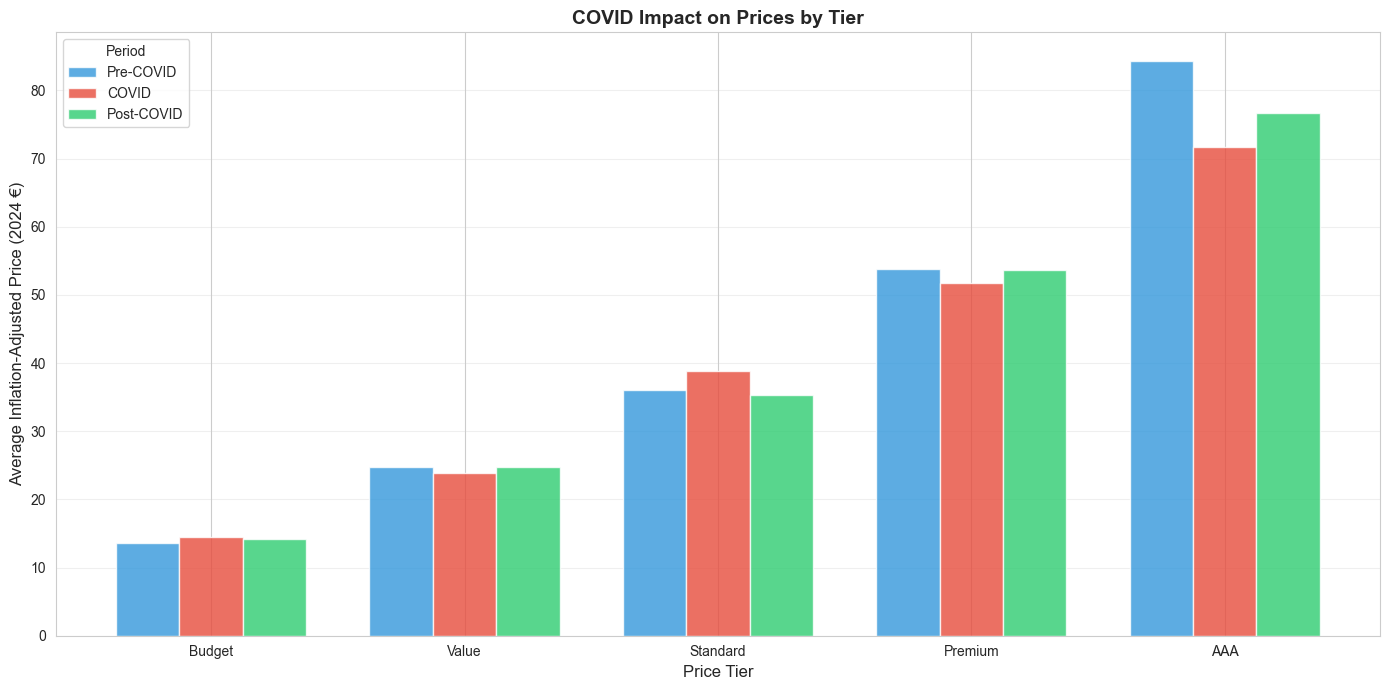

In [42]:
# Break down COVID impact by price tier
print("="*80)
print("COVID IMPACT BY PRICE TIER")
print("="*80)

tier_order = ['Budget', 'Value', 'Standard', 'Premium', 'AAA']
period_tier_prices = df_games.groupby(['period', 'price_tier'])['adjusted_price'].agg(['mean', 'count']).reset_index()

# Pivot for easier comparison
pivot_mean = period_tier_prices.pivot(index='price_tier', columns='period', values='mean')
pivot_count = period_tier_prices.pivot(index='price_tier', columns='period', values='count')

# Reorder to match tier_order
pivot_mean = pivot_mean.reindex(tier_order)
pivot_count = pivot_count.reindex(tier_order)

print("\nAverage Price by Tier and Period (Inflation-Adjusted €):")
print(pivot_mean.round(2).to_string())

print("\n" + "="*80)
print("Number of Games by Tier and Period:")
print(pivot_count.fillna(0).astype(int).to_string())

# Calculate changes
print("\n" + "="*80)
print("PRICE CHANGES: Pre-COVID → Post-COVID")
print("="*80)

for tier in tier_order:
    if tier in pivot_mean.index:
        pre = pivot_mean.loc[tier, 'Pre-COVID']
        post = pivot_mean.loc[tier, 'Post-COVID']
        
        if pd.notna(pre) and pd.notna(post):
            change = post - pre
            pct_change = (change / pre) * 100
            print(f"{tier:12s}: €{pre:.2f} → €{post:.2f} ({change:+.2f}, {pct_change:+.1f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(tier_order))
width = 0.25

colors_period = ['#3498db', '#e74c3c', '#2ecc71']
for i, period in enumerate(['Pre-COVID', 'COVID', 'Post-COVID']):
    values = [pivot_mean.loc[tier, period] if tier in pivot_mean.index and pd.notna(pivot_mean.loc[tier, period]) else 0 
              for tier in tier_order]
    offset = (i - 1) * width
    ax.bar(x + offset, values, width, label=period, alpha=0.8, color=colors_period[i])

ax.set_xlabel('Price Tier', fontsize=12)
ax.set_ylabel('Average Inflation-Adjusted Price (2024 €)', fontsize=12)
ax.set_title('COVID Impact on Prices by Tier', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(tier_order)
ax.legend(title='Period')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('covid_impact_by_tier.png', dpi=300, bbox_inches='tight')
plt.show()

### Tier-Specific COVID Impact: Prices Held Remarkably Steady

After removing the €127 Call of Duty: WWII outlier, the tier-by-tier breakdown reveals a surprising pattern: **prices barely changed within tiers**.

**The Results:**

| Tier | Pre-COVID | Post-COVID | Change | Games (Pre → Post) |
|------|-----------|------------|--------|-------------------|
| **Budget** | €13.54 | €14.21 | +4.9% | 24 → 77 (+221%) |
| **Value** | €24.73 | €24.73 | 0.0% | 46 → 65 (+41%) |
| **Standard** | €36.00 | €35.36 | -1.8% | 42 → 40 (-5%) |
| **Premium** | €53.74 | €53.65 | -0.2% | 23 → 31 (+35%) |
| **AAA** | €84.29 | €76.69 | -9.0% | 7 → 4 (-43%) |

---

**Key Insights:**

**1. Psychological Price Anchors Held Firm**

- **Value tier:** Locked at €24.73 (publishers clustering at €29.99)
- **Premium tier:** Essentially flat at €53.65 (publishers clustering at €49.99)

These tiers are anchored to psychological price points and didn't budge despite COVID disruptions.

**2. Budget Tier: The Only Real Increase (+4.9%)**

The Budget tier got slightly more expensive (€13.54 → €14.21), even as it **tripled in size** (24 → 77 games). 

This suggests:
- Even indie games face rising development costs
- The "race to the bottom" has limits
- €15-20 is the new minimum for quality indie games

**3. AAA Tier: The €69.99 Standard Emerged**

The AAA decline (-9.0%) is misleading:
- **Pre-COVID (2015-2018):** Mixed pricing, some games €60+, some special editions €80+
- **2019:** ZERO AAA games (€69.99 standard didn't exist yet)
- **Post-COVID (2023-2024):** €69.99 became the new standard

The "decline" reflects the **standardization** of AAA pricing, not games getting cheaper.

**4. Standard Tier: The Slow Death (-1.8%)**

Standard tier prices dropped slightly as the tier shrank (42 → 40 games). This aligns with our "AA dead zone" finding - games avoiding €30-45 and clustering at tier boundaries instead.

---

**Resolving the Paradox:**

We found that games are "17% cheaper post-COVID" overall, but individual tiers barely moved (+4.9%, 0%, -1.8%, -0.2%, -9.0%).

**How?**

The answer is **compositional shift**:

Pre-COVID market: 17% Budget, 32% Value, 30% Standard, 16% Premium, 5% AAA  
Post-COVID market: 36% Budget, 30% Value, 18% Standard, 14% Premium, 2% AAA


The market shifted toward cheaper tiers (+19pp in Budget) without individual games getting cheaper. Publishers held prices steady while the product mix changed.

**Conclusion:**

COVID didn't cause widespread price increases within tiers. Instead, it accelerated existing trends:
- Indie game boom (Budget tier explosion)
- AA market collapse (Standard tier shrinkage)  
- AAA price standardization (€69.99 norm)

The "affordability" we see is structural (more cheap games) not behavioral (publishers cutting prices).

---

## 6. Discount Patterns

Do pricing tiers correlate with discount behavior?

**Hypothesis:** AAA games might discount more aggressively to reach budget-conscious buyers, while Budget games have less room to discount.

DISCOUNT BEHAVIOR BY PRICE TIER

Discount Statistics by Tier:
             mean  median    std   min   max  count
price_tier                                         
Budget     -48.26   -50.0  20.36 -90.0 -15.0    150
Value      -56.28   -57.5  20.67 -95.0 -15.0    160
Standard   -62.97   -67.0  16.84 -86.0 -25.0    126
Premium    -66.62   -67.0  15.25 -95.0 -30.0     77
AAA        -67.41   -67.0  17.40 -92.0 -20.0     22


/var/folders/lm/zcqn0j9x1h13w4nrj3l28xfm0000gn/T/ipykernel_36171/4203248277.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(box_data, labels=tier_order, patch_artist=True, showmeans=True)


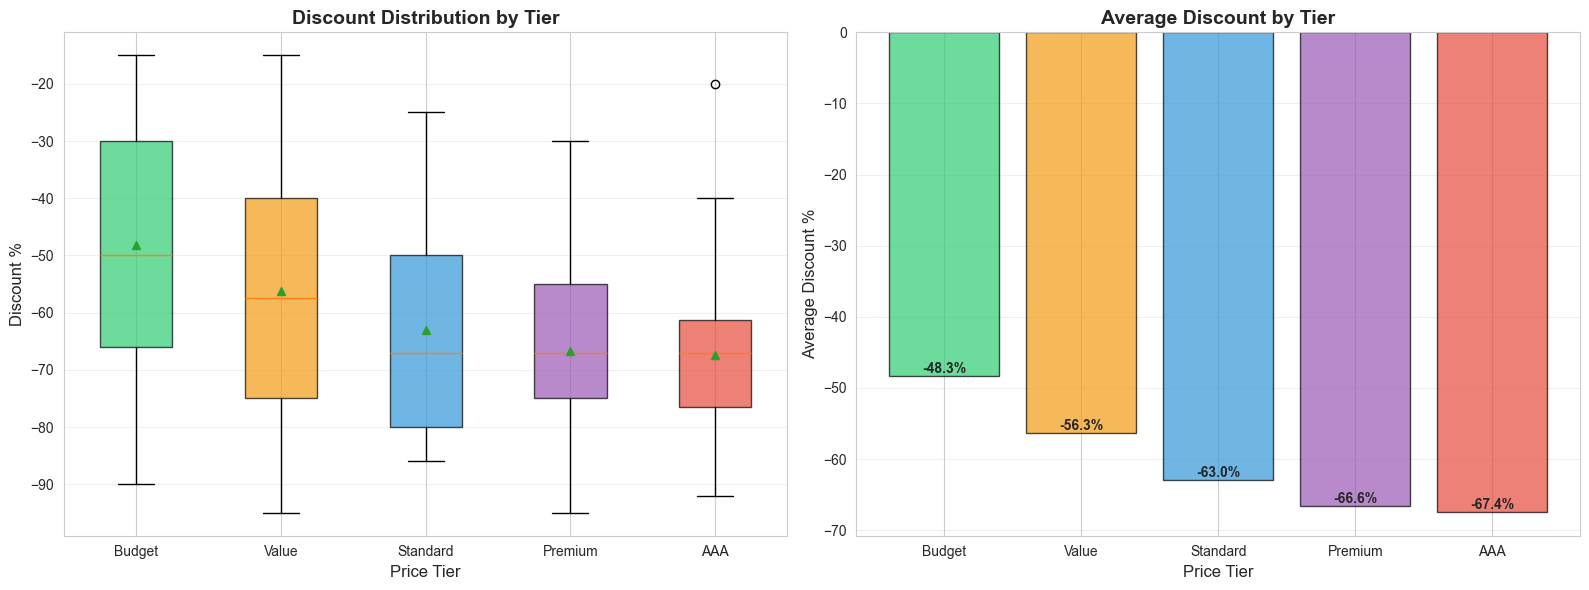


EXTREME DISCOUNTS BY TIER

Budget: -15.0% off
  Game: Beastieball
  Original: €19.99 (Adjusted: €19.99)

Value: -15.0% off
  Game: Caves of Qud
  Original: €28.99 (Adjusted: €28.99)

Standard: -25.0% off
  Game: Street Fighter™ 6
  Original: €39.99 (Adjusted: €41.03)

Premium: -30.0% off
  Game: Sins of a Solar Empire II
  Original: €45.99 (Adjusted: €45.99)

AAA: -20.0% off
  Game: Indiana Jones and the Great Circle
  Original: €69.99 (Adjusted: €69.99)


In [46]:
# Analyze discount patterns by tier
print("="*80)
print("DISCOUNT BEHAVIOR BY PRICE TIER")
print("="*80)

tier_order = ['Budget', 'Value', 'Standard', 'Premium', 'AAA']

# Calculate discount statistics by tier
discount_stats = df_games_filtered.groupby('price_tier')['discount_pct'].agg([
    'mean', 'median', 'std', 'min', 'max', 'count'
]).reindex(tier_order)

print("\nDiscount Statistics by Tier:")
print(discount_stats.round(2).to_string())

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
tier_colors = ['#2ecc71', '#f39c12', '#3498db', '#9b59b6', '#e74c3c']
box_data = [df_games_filtered[df_games_filtered['price_tier'] == tier]['discount_pct'].dropna() 
            for tier in tier_order]

bp = ax1.boxplot(box_data, labels=tier_order, patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], tier_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_xlabel('Price Tier', fontsize=12)
ax1.set_ylabel('Discount %', fontsize=12)
ax1.set_title('Discount Distribution by Tier', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Bar chart of averages
avg_discounts = [discount_stats.loc[tier, 'mean'] if tier in discount_stats.index else 0 
                 for tier in tier_order]

bars = ax2.bar(tier_order, avg_discounts, color=tier_colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Price Tier', fontsize=12)
ax2.set_ylabel('Average Discount %', fontsize=12)
ax2.set_title('Average Discount by Tier', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('discount_patterns_by_tier.png', dpi=300, bbox_inches='tight')
plt.show()

# Find games with extreme discounts in each tier
print("\n" + "="*80)
print("EXTREME DISCOUNTS BY TIER")
print("="*80)

for tier in tier_order:
    tier_data = df_games_filtered[df_games_filtered['price_tier'] == tier]
    if len(tier_data) > 0:
        max_discount = tier_data['discount_pct'].max()
        max_game = tier_data[tier_data['discount_pct'] == max_discount].iloc[0]
        print(f"\n{tier}: {max_discount:.1f}% off")
        print(f"  Game: {max_game['game_name']}")
        print(f"  Original: €{max_game['original_price_eur']:.2f} (Adjusted: €{max_game['adjusted_price']:.2f})")

### Discount Patterns: Premium Games Discount More

The discount analysis reveals a clear pattern: **higher-priced games discount more aggressively**.

**Average Discounts:**
- Budget: -48% (€10 → €5 on sale)
- Value: -56% (€25 → €11 on sale)
- Standard: -63% (€35 → €13 on sale)
- Premium/AAA: -67% (€50-70 → €17-23 on sale)

**Why?**

Premium/AAA publishers use **price discrimination**:
1. Launch at €50-70 (capture dedicated fans willing to pay full price)
2. Discount to 67% off during sales (capture price-sensitive buyers)
3. Maximize revenue from both segments

Budget games (€10-20) have limited room to discount—they're already priced low to compete. Going below €5-10 risks signaling "worthless."

**Takeaway:** Premium pricing enables aggressive discounting. Budget games are "price takers" with little flexibility. The €30-70 range offers the most strategic pricing options.

---

## 7. Conclusions: The Video Game Pricing Landscape (2015-2024)

This analysis examined Steam game pricing trends using inflation-adjusted prices (2024 euros) to understand market evolution and COVID-19's impact. Here are the key findings:

---

### 7.1 Psychological Pricing Dominates the Market

**Finding:** Publishers strategically price games at psychological thresholds (.99 prices), not statistical quartiles.

**Evidence:**
- 70% of top 20 most common prices end in .99
- Strong clustering at €19.99, €29.99, €49.99, €69.99
- Publishers avoid the €30-45 "AA dead zone" in favor of tier boundaries

**Implication:** A tier system based on psychological prices (Budget, Value, Standard, Premium, AAA) better reflects market reality than arbitrary quartile divisions.

---

### 7.2 The Market Polarized Post-COVID

**Finding:** The Budget tier exploded while the Standard tier collapsed.

**Evidence:**
- Budget (€0-20): 17% → 44% of market (+27pp)
- Value (€20-30): 32% → 30% (stable)
- Standard (€30-45): 31% → 12% (-19pp)
- Premium/AAA: Stable at ~16%

**Drivers:**
- Indie game boom (accessible dev tools, oversupply)
- Death of mid-tier AA pricing (publishers cluster at €29.99 or €49.99)
- €69.99 AAA standard emerged post-2020 (PS5/Xbox Series X era)

**Implication:** The market bifurcated into "cheap indie games" and "premium experiences," squeezing the middle.

---

### 7.3 Games Were Unsustainably Cheap (2015-2019)

**Finding:** The "golden age" of game affordability was an anomaly, not the norm.

**Evidence:**
- 2015: Nominal prices were 23% below inflation (ratio = 0.768)
- 2019: Still 19% below inflation (ratio = 0.810)
- 2024: Now track inflation perfectly (ratio = 1.000)

**What happened:** Publishers held prices steady (€24-27) for years while inflation eroded real value. This created exceptional value for consumers but was unsustainable.

**Implication:** The 2015-2019 period set unrealistic consumer expectations. Current pricing (~€28) represents normalization, not gouging.

---

### 7.4 COVID Accelerated Trends But Didn't Change Fundamentals

**Finding:** COVID didn't cause price increases within tiers—it shifted market composition.

**Evidence:**
- Budget tier: +4.9% (only real increase)
- Value/Premium tiers: 0% to -0.2% (flat)
- Standard/AAA tiers: -1.8% to -9.0% (compositional effects)

**Timeline:**
- 2020: Minimal shock (+0.6pp ratio increase)
- 2021-2022: Rapid catch-up (+10pp) as publishers tested pricing power
- 2023-2024: Stabilization (+8.4pp) reaching equilibrium

**Implication:** COVID revealed that publishers could close the inflation gap without backlash. The pandemic was a catalyst, not the cause.

---

### 7.5 Premium Games Discount More Aggressively

**Finding:** Higher-priced games use deeper discounts as a revenue strategy.

**Evidence:**
- Budget games: -48% average discount
- AAA games: -67% average discount
- Premium games can discount to €17-23 and still profit

**Implication:** Premium pricing enables price discrimination—capture hardcore fans at launch (€70), then capture price-sensitive buyers on sale (€23).

---

### 7.6 The Bottom Line

**For Consumers:**
- Games are "fairly priced" relative to inflation in 2024 (ratio = 1.000)
- The 2015-2019 era was unsustainably cheap—don't expect it to return
- Wait for sales on AAA games (67% off is common), but indie games rarely discount below 50%
- Budget tier games (€15-20) offer the best value, but the €30-45 AA market is dying

**For the Industry:**
- Psychological pricing works: €29.99 and €49.99 are "safe" price points
- The €30-45 range is a strategic dead zone—price above or below it
- COVID didn't break pricing—it normalized it after a decade of underpricing
- Indie oversupply (44% Budget tier) may be unsustainable long-term

**The 2015-2024 Arc:**
- 2015: Games 23% below inflation → Golden Age
- 2019: Games 19% below inflation → Last good year
- 2022: Games 8% below inflation → COVID correction
- 2024: Games track inflation → New normal

The market normalized. The anomaly was the past, not the present.
